In [1]:
import itertools
import unicodedata
import re
import os
from pathlib import Path
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import tabulate
import matplotlib
from  matplotlib.ticker import FuncFormatter
import networkx as nx

In [2]:
def contingency_statistics(contingency):
    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency)
    association = scipy.stats.contingency.association(contingency)
    return {
        "chi^2": chi2,
        "p": p,
        "df": dof,
        "V": association
    }

def u_test(groups, names):
    groups = [group[~np.isnan(group)] for group in groups]
    
    U = {}
    p = {}
    r = {}
    N1 = {}
    N2 = {}
    
    for i1, g1 in enumerate(groups):
        for i2, g2 in enumerate(groups):
            if i1 < i2:
                name1, name2 = names[i1], names[i2]
                U[name1, name2], p[name1, name2] = scipy.stats.mannwhitneyu(g1, g2, alternative="two-sided")
    
                N1[name1, name2] = len(g1)
                N2[name1, name2] = len(g2)

                U1 = U[name1, name2]
                U2 = N1[name1, name2] * N2[name1, name2] - U1
                U_min = min(U1, U2)

                r[name1, name2] = 1 - (2 * U_min) / (N1[name1, name2] * N2[name1, name2])
    return pd.DataFrame({"U": U, "p": p, "r": r, "N_1": N1, "N_2": N2})       

def chi2_deluxe(xtab):
    chi2_stat, p, dof, expected = scipy.stats.contingency.chi2_contingency(xtab)
    chi2_contributions = (xtab - expected) ** 2 / expected
    p_values = chi2_contributions.apply(lambda chi2: scipy.stats.chi2.sf(chi2, df=1))
    num_cells = xtab.size  # Total number of cells (rows * columns)
    def mark_significance(p_value):
        correction = num_cells  # Use the number of cells for Bonferroni correction
        if p_value < 0.001 / correction:
            return '***'
        elif p_value < 0.01 / correction:
            return '**'
        elif p_value < 0.05 / correction:
            return '*'
        else:
            return 'n. s.'
    significance = p_values.map(mark_significance)
    signs = np.sign(xtab - expected).map(lambda x: "+" if x > 0 else "–")
    results = pd.DataFrame(index=xtab.index, columns=xtab.columns)
    
    for row in xtab.index:
        for col in xtab.columns:
            chi2_value = chi2_contributions.loc[row, col]
            sign = signs.loc[row, col]
            p_value = p_values.loc[row, col]
            sig = significance.loc[row, col]
            results.loc[row, col] = f"{sign}, χ² = {chi2_value:.2f} {sig}"

    return results

def add_external_history(ax):
    ax.axvline(x=451, color='red', linestyle=':', linewidth=1, label="Council of Chalcedon")
    ax.axvline(x=705, color='green', linestyle=':', linewidth=1, label="Arabic administration")

In [3]:
pd.set_option("styler.format.decimal", ".")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")

plt.rcParams['figure.figsize'] = (8, 4) 
plt.rcParams['svg.fonttype'] = 'none' # ref https://stackoverflow.com/a/35734729

sns.set_style("ticks")
sns.set_context("paper")
cm = plt.cm.Blues

import os.path

font_dir = "/nix/var/nix/profiles/system/sw/share/X11/fonts"
if os.path.exists(font_dir):
    font_files = matplotlib.font_manager.findSystemFonts(fontpaths=[font_dir])
    matplotlib.font_manager.fontManager.addfont(font_dir + "/" + "Junicode-Regular.ttf")
    matplotlib.font_manager.fontManager.addfont(font_dir + "/" + "Antinoou.ttf")

    plt.rcParams["font.family"] = ["Junicode", "Antinoou"]
elif antinoou := os.getenv("ANTINOOU_FONT"):
    matplotlib.font_manager.fontManager.addfont(antinoou)
    plt.rcParams["font.family"] = ["Antinoou"]

### Assets Export

In [4]:
import json

subdirectory = Path("assets")
subdirectory.mkdir(exist_ok=True)

def write_figure(the_name):
    plt.savefig(subdirectory / f"figure-{the_name}.svg")

def write_json(datum, the_name):
    with open(subdirectory / (the_name + '.json'), "w") as file:
        json.dump(datum, file)

def write_csv(df, the_name):
    df.to_csv(subdirectory / (the_name + '.csv'), float_format='%.2f')  

def write_table(df, the_name, caption="", heatmap=False, as_ints=False, axis=None):
    style = df.style.format(precision=0, na_rep="–") if as_ints else df.style
    style = style if not heatmap else style.background_gradient(axis=axis, cmap=cm)
    with (subdirectory / f"table-{the_name}.tex").open(mode="w") as f:
        f.write(
            (style).highlight_null(props="background-color:white; color:white;").to_latex(
                convert_css=True, 
                hrules=True,
                sparse_index=False,
                environment="longtable", 
                position="!hbt", 
                caption=caption, 
                label="tbl:"+the_name
            )
        )
    with (subdirectory / f"table-{the_name}.html").open(mode="w") as f:
        f.write((style).highlight_null(props="opacity:0").to_html(sparse_index=False))
    with (subdirectory / f"table-{the_name}.md").open(mode="w") as f:
        if caption:
            f.write(f"Table: {caption}\n\n")
        f.write(df.to_markdown(floatfmt=".2f").replace("nan", "\u00a0").replace(".00", "   ").replace(".", ",")) #ma

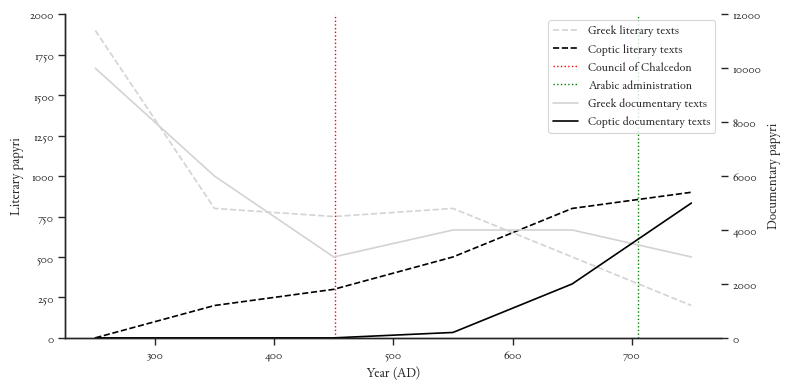

In [5]:
import matplotlib.pyplot as plt

periods = [250, 350, 450, 550, 650, 750]
greek_lit = [1900, 800, 750, 800, 500, 200]
coptic_lit = [0, 200, 300, 500, 800, 900]
greek_doc = [10000, 6000, 3000, 4000, 4000, 3000]
coptic_doc = [0, 0, 0, 200, 2000, 5000]

# Create plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("Year (AD)")

ax1.plot(periods, greek_lit, linestyle='--', color='lightgray', label='Greek literary texts')
ax1.plot(periods, coptic_lit, linestyle='--', color='black', label='Coptic literary texts')
ax2.plot(periods, greek_doc, linestyle='-', color='lightgray', label='Greek documentary texts')
ax2.plot(periods, coptic_doc, linestyle='-', color='black', label='Coptic documentary texts')
ax1.set_ylabel("Literary papyri")
ax2.set_ylabel("Documentary papyri")
ax1.set_ylim(0, 2000)
ax2.set_ylim(0, 12000)

add_external_history(ax1)

# Combine and show legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.tight_layout()
sns.despine(trim=False)
write_figure("greek_coptic_lit_doc")
plt.show()


# Data overview

In [6]:
df_attestations = pd.read_csv("attestations.csv")

/tmp/nix-shell.wTW14Y/ipykernel_2124977/109604783.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_attestations = pd.read_csv("attestations.csv")


In [7]:
df_diff = pd.read_csv("deviations.csv")

In [8]:
df_diff.dialect.unique()

array(['L5', 'S', 'F', 'V', 'W', 'B', 'A', 'L', 'L6', 'M', 'L4', 'H'],
      dtype=object)

In [9]:
dialect_groups = list("BFMSLA")
dialects = ["B", "F", "V", "M", "W", "S", "H", "L", "L4", "L5", "L6", "A", "P"]

df_diff["dialect_group"] = pd.Categorical(df_diff["dialect_group"], dialect_groups)
df_diff["dialect"] = pd.Categorical(df_diff["dialect"], dialects)

df_attestations["dialect_group"] = pd.Categorical(df_attestations["dialect_group"], dialect_groups)
df_attestations["dialect"] = pd.Categorical(df_attestations["dialect"], dialects)

In [10]:
number_of_bins = 10

full_dates = df_attestations['date_approximate'].dropna()
bins = np.linspace(full_dates.min(), full_dates.max(), number_of_bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

full_counts, _ = np.histogram(full_dates, bins=bins)
full_counts_safe = np.where(full_counts == 0, 1e-8, full_counts)

#pd.DataFrame([bins, full_counts], index=["bin-start", "datapoints"]).T

def y():
    results = []
    for dialect, group in df_attestations.groupby('dialect_group'):
        group_dates = group['date_approximate'].dropna()
        full_counts, _ = np.histogram(group_dates, bins=bins)
        for bin_number in range(len(full_counts)):
            results.append({
                'dialect_group': dialect,
                'bin_number': bin_number,
                'bin_start': bins[bin_number],
                'datapoints': full_counts[bin_number]
            })
    full_counts_per_dialect = pd.DataFrame(results)
    full_counts_per_dialect.set_index(['bin_number', 'dialect_group'], inplace=True)
    full_counts_per_dialect['datapoints'] = np.where(final_df['datapoints'] == 0, 1e-8, final_df['datapoints'])
    full_counts_per_dialect = full_counts_per_dialect['datapoints'].unstack(level='dialect_group')
    full_counts_per_dialect

results = []
for dialect, group in df_attestations.groupby('dialect_group'):
    full_counts, _ = np.histogram(group['date_approximate'].dropna(), bins=bins)
    results.extend([{
        'bin_number': bin_number,
        'dialect_group': dialect,
        'bin_start': bins[bin_number],
        'datapoints': count
    } for bin_number, count in enumerate(full_counts)])
full_counts_per_dialect = pd.DataFrame(results)
full_counts_per_dialect = full_counts_per_dialect.pivot_table(
    index='bin_number',
    columns='dialect_group',
    values='datapoints',
    fill_value=1e-8  # Replace NaN with a small value
)
full_counts_per_dialect = full_counts_per_dialect.replace(0, 1e-8)
full_counts_per_dialect

/tmp/nix-shell.wTW14Y/ipykernel_2124977/1748566331.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for dialect, group in df_attestations.groupby('dialect_group'):


dialect_group,A,B,F,L,M,S
bin_number,,,,,,
0,3.125000e+03,1.363000e+03,4.530000e+02,2.451000e+03,1.000000e-08,3238.0
1,8.020000e+02,1.000000e-08,1.610000e+02,2.301000e+03,6.721000e+03,9297.0
2,2.710000e+02,1.000000e-08,6.900000e+01,1.000000e-08,2.400000e+01,1808.0
3,1.000000e-08,1.000000e-08,1.230000e+02,1.000000e-08,1.000000e-08,9515.0
4,1.000000e-08,9.670000e+02,1.480000e+02,1.000000e-08,1.000000e-08,7094.0
5,1.000000e-08,7.000000e+00,7.400000e+01,1.000000e-08,1.000000e-08,14334.0
6,1.000000e-08,2.170000e+02,8.870000e+02,1.000000e-08,1.000000e-08,14699.0
7,1.000000e-08,4.000000e+00,4.300000e+01,1.000000e-08,1.000000e-08,3937.0
8,1.000000e-08,1.388000e+03,1.000000e-08,1.000000e-08,1.000000e-08,977.0


In [11]:
df_dialects = df_attestations.groupby("dialect_group").agg({
    "manuscript_text": ['nunique'],
    "greek_lemma": ['count', 'nunique'],
    "earliest": ['min'],
    "latest": ['max'],
})
write_csv(df_dialects, "dialects_all")
df_dialects

/tmp/nix-shell.wTW14Y/ipykernel_2124977/1630693263.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dialects = df_attestations.groupby("dialect_group").agg({


manuscript_text greek_lemma         earliest  latest
                      nunique       count nunique      min     max
dialect_group                                                     
B                          39        9181    1109    300.0  1249.0
F                          69        3405     571    200.0  1199.0
M                          19        8421     683    364.0   599.0
S                        2914      160092    4401    200.0  1299.0
L                         130        8358     956    200.0   499.0
A                          26        5589     611    300.0   599.0

In [12]:
df_dialects = df_attestations[~np.isnan(df_attestations.date_approximate)].groupby("dialect_group").agg({
    "manuscript_text": ['nunique'],
    "greek_lemma": ['count', 'nunique'],
    "date_approximate": ['min', 'median', 'max'],
})
write_csv(df_dialects, "dialects_dated")
df_dialects

/tmp/nix-shell.wTW14Y/ipykernel_2124977/2183164698.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dialects = df_attestations[~np.isnan(df_attestations.date_approximate)].groupby("dialect_group").agg({


manuscript_text greek_lemma         date_approximate         \
                      nunique       count nunique              min median   
dialect_group                                                               
B                          16        3946     748            349.5  699.5   
F                          48        1950     394            299.5  799.5   
M                          10        6743     628            398.5  449.5   
S                        1522       64534    3152            299.5  849.5   
L                         119        4719     695            249.5  349.5   
A                          11        4195     520            349.5  349.5   

                       
                  max  
dialect_group          
B              1212.0  
F              1099.5  
M               549.5  
S              1149.5  
L               404.0  
A               499.5

<Axes: xlabel='material', ylabel='accuracy'>

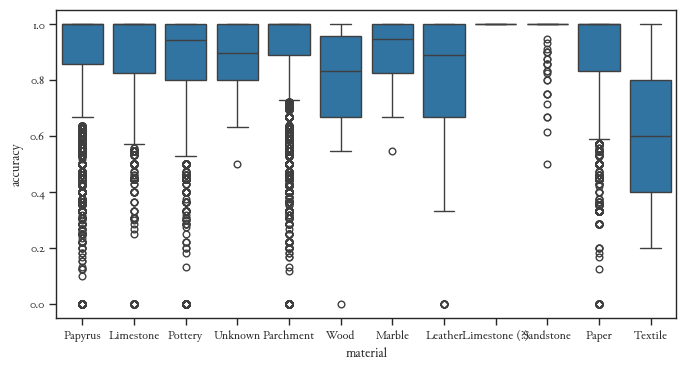

In [13]:
sns.boxplot(df_attestations, y="accuracy", x="material")

<Axes: xlabel='accuracy', ylabel='Count'>

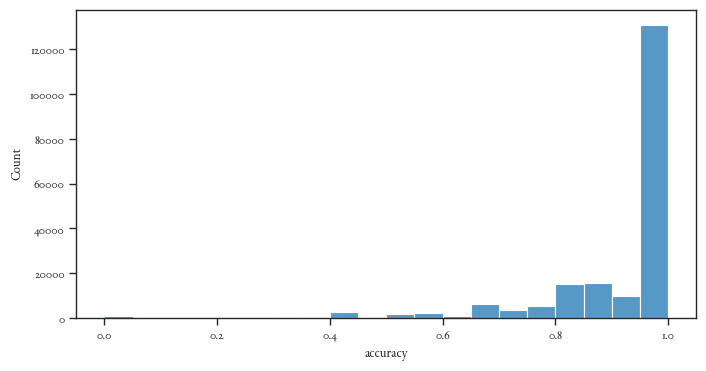

In [14]:
sns.histplot(df_attestations.accuracy, bins=20)

# Is there an influence of era on spelling accuracy?

In [15]:
from difflib import SequenceMatcher
df_attestations["accuracy"] = df_attestations.dropna(subset=["greek_lemma", "orthography_clean"]).apply(lambda row: SequenceMatcher(None, row["greek_lemma"], row["orthography_clean"]).ratio(), axis=1)

In [16]:
categories = ["pre-chalcedon", "post-chalcedon", "arab"]

# Apply the lambda function to determine the era
df_attestations["era"] = df_attestations["date_approximate"].dropna().apply(
    lambda date: "pre-chalcedon" if date < 451 else "post-chalcedon" if date < 705 else "arab"
)

# Convert to categorical with the specified categories
df_attestations["era"] = pd.Categorical(df_attestations["era"], categories=categories)

In [17]:
quartiles_era = df_attestations.groupby("era")["accuracy"].quantile([0.25, 0.5, 0.75]).unstack()
write_csv(quartiles_era, "quartiles_era")
quartiles_era

/tmp/nix-shell.wTW14Y/ipykernel_2124977/4052961847.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartiles_era = df_attestations.groupby("era")["accuracy"].quantile([0.25, 0.5, 0.75]).unstack()


,0.25,0.50,0.75
era,,,
pre-chalcedon,0.933333,1.0,1.0
post-chalcedon,0.857143,1.0,1.0
arab,0.857143,1.0,1.0


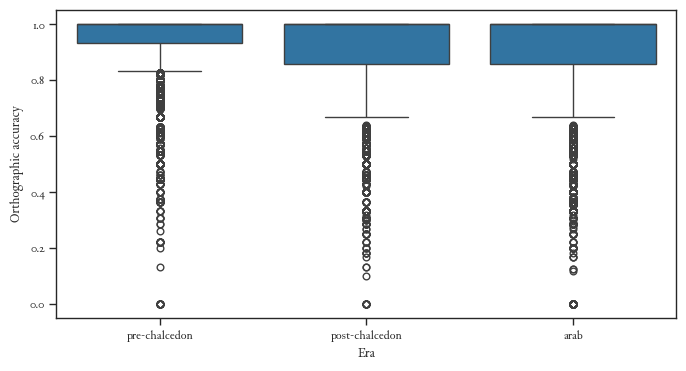

In [18]:
sns.boxplot(df_attestations, y="accuracy", x="era")
#plt.yscale("log")
plt.ylabel("Orthographic accuracy")
plt.xlabel("Era")
#plt.ylim(0.5, 1)
#sns.despine(trim=True)
write_figure("accuracy_by_era")

In [19]:
names = ["pre-chalcedon", "post-chalcedon", "arab"]

groups = [
    df_attestations[df_attestations["era"] == name]["accuracy"].values for name in names
]


era_results = u_test(groups, names)
era_results.index = era_results.index.map(lambda x: ' vs. '.join(x))
write_csv(era_results, "era_u")
era_results

,U,p,r,N_1,N_2
pre-chalcedon vs. post-chalcedon,245221210.5,1.744098e-173,0.133044,29678,14585
pre-chalcedon vs. arab,708373437.5,0.000000e+00,0.141385,29678,41824
post-chalcedon vs. arab,308159965.5,3.416647e-02,0.010356,14585,41824


In [20]:
#slope, intercept, r_value, p_value, std_err = 
lin_df = df_attestations.dropna(subset=["date_approximate", "accuracy"])
scipy.stats.linregress(lin_df.date_approximate, lin_df.accuracy)

LinregressResult(slope=-5.892502907784935e-05, intercept=0.9625094761078302, rvalue=-0.10759988826551173, pvalue=5.195393468438591e-220, stderr=1.8556475941191995e-06, intercept_stderr=0.0013571703789819973)

<Axes: xlabel='date_approximate', ylabel='accuracy'>

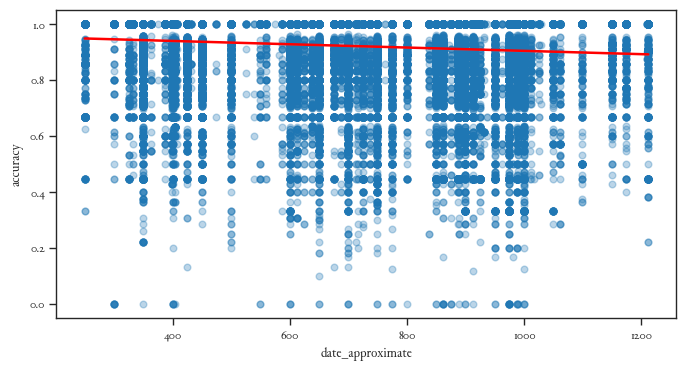

In [21]:
df_attestations["rolling_average_accuracy"] = df_attestations['accuracy'].rolling(window=10).mean()
sns.regplot(df_attestations, x="date_approximate", y="accuracy", scatter_kws=dict(alpha=0.3), line_kws={'color': 'red'})

# How does the rate of deviations develop across time?

/tmp/nix-shell.wTW14Y/ipykernel_2124977/3247862650.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_manuscript_counts = df_attestations.groupby('bin')['manuscript_text'].nunique()


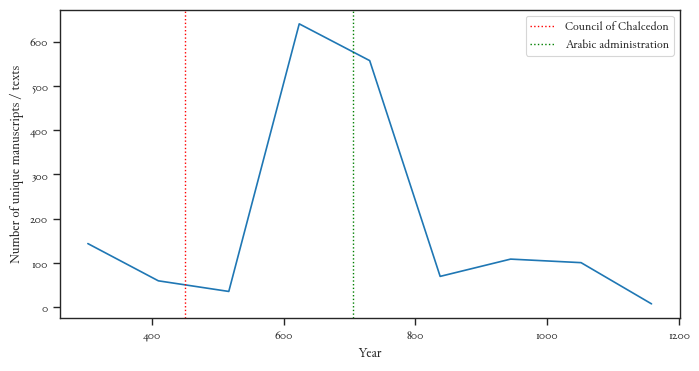

In [22]:
df_attestations['bin'] = pd.cut(df_attestations['date_approximate'], bins=bins)
unique_manuscript_counts = df_attestations.groupby('bin')['manuscript_text'].nunique()

# Plot the absolute number of unique "manuscript_text" values
ax = sns.lineplot(x=bin_centers, y=unique_manuscript_counts.values)
add_external_history(ax)
plt.xlabel('Year')
plt.ylabel('Number of unique manuscripts / texts')
plt.legend()
plt.show()

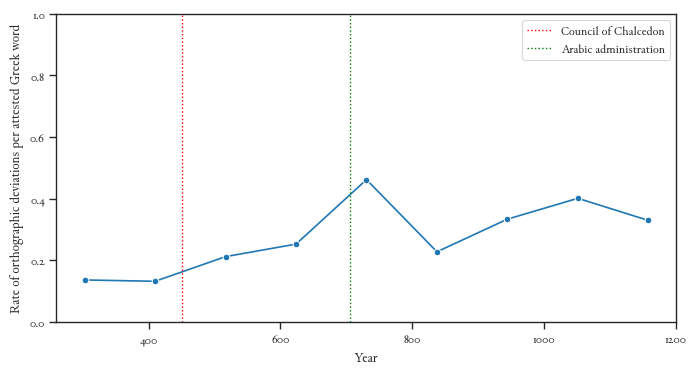

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x1 = df_diff['date_approximate'].dropna()
counts1, _ = np.histogram(x1, bins=bins)
ratio = counts1 / full_counts_safe

ax = sns.lineplot(x=bin_centers, y=ratio, marker="o")
add_external_history(ax)
plt.xlabel('Year')
plt.ylabel('Rate of orthographic deviations per attested Greek word')
plt.ylim(0,1)
plt.legend()
#sns.despine()

write_figure("attestations_by_deviations")

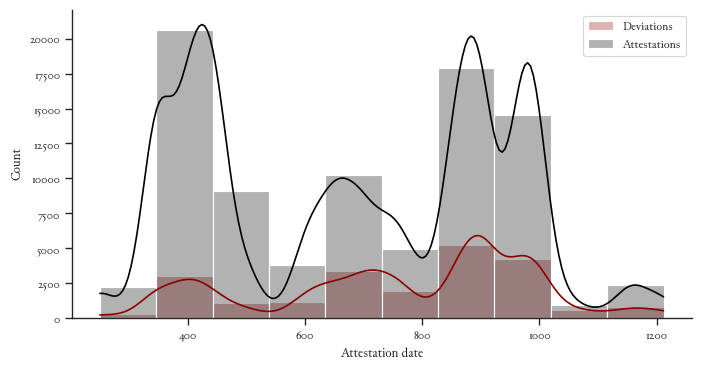

In [24]:
sns.histplot(
    data=df_diff,
    x='date_approximate',
    bins=number_of_bins,
    kde=True,
    color='darkred',
    label='Deviations',
    alpha=0.3
)

sns.histplot(
    data=df_attestations,
    x='date_approximate',
    bins=number_of_bins,
    kde=True,
    color='black',
    label='Attestations',
    alpha=0.3
)

# Styling
sns.despine(trim=False)
plt.legend()
plt.xlabel("Attestation date")
plt.ylabel("Count")
write_figure("attestations_deviations")

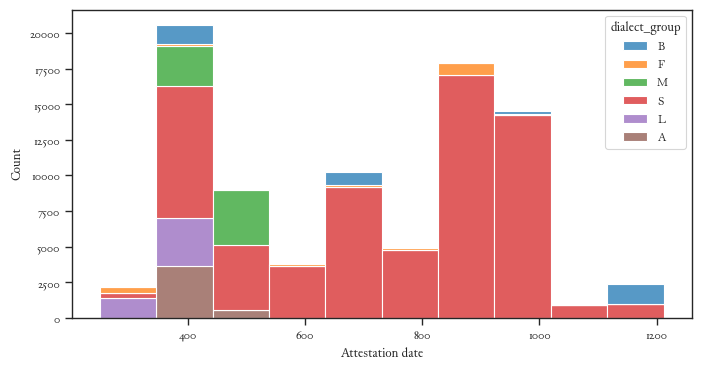

In [25]:
sns.histplot(
    data=df_attestations,
    x='date_approximate',
    bins=number_of_bins,
    hue="dialect_group",
    multiple="stack",
)


#sns.despine(trim=False)
#plt.legend(True)
plt.xlabel("Attestation date")
plt.ylabel("Count")
write_figure("attestations_dialects")

# How does the rate of deviations behave across dialects?

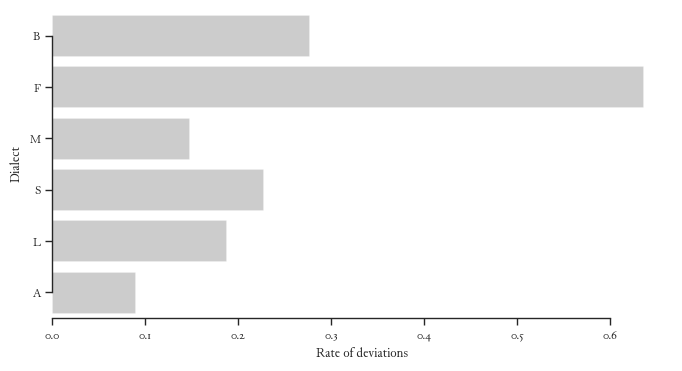

In [26]:
dialect_ratios = df_diff["dialect_group"].value_counts() / df_attestations["dialect_group"].value_counts()
dialect_ratios_df = dialect_ratios.reset_index()
dialect_ratios_df.columns = ["Dialect", "Rate of deviations"]
sns.barplot(dialect_ratios_df, x="Rate of deviations", y="Dialect", color="black", alpha=0.2)
sns.despine(trim=True)
write_figure("deviations_by_dialect")

In [27]:
names = dialect_groups

groups = [
    df_attestations[df_attestations["dialect_group"] == name]["accuracy"].values for name in names
]


dial_results = u_test(groups, names)
dial_results.index = dial_results.index.map(lambda x: ' vs. '.join(x))
write_csv(dial_results, "dialects_u")
dial_results#.style.background_gradient(axis="rows", cmap=cm)

,U,p,r,N_1,N_2
B vs. F,18132866.0,2.827542e-58,0.160084,9181,3405
B vs. M,37588289.0,1.097472e-04,0.027636,9181,8421
B vs. S,742533272.5,4.606534e-02,0.010384,9181,160092
B vs. L,37132463.0,6.570491e-06,0.032187,9181,8358
B vs. A,22322509.0,1.611372e-63,0.129941,9181,5589
F vs. M,11601719.0,5.030165e-82,0.190771,3405,8421
F vs. S,230552813.5,1.018695e-74,0.154110,3405,160092
F vs. L,11446215.0,1.881913e-86,0.195599,3405,8358
F vs. A,6769252.5,6.016368e-177,0.288591,3405,5589
M vs. S,699921461.0,1.439451e-12,0.038355,8421,160092


In [28]:
import pandas as pd

def is_significant(p):
    return "***" if p < 0.0001 else "**" if p < 0.001 else "*" if p < 0.01 else ""

groups = sorted(list(set([comp.split(" vs. ")[0] for comp in dial_results.index] + [comp.split(" vs. ")[1] for comp in dial_results.index])))
significance_matrix = pd.DataFrame(index=groups, columns=groups)

for group1 in groups:
    for group2 in groups:
        if group1 == group2:
            significance_matrix.loc[group1, group2] = "—"
        else:
            comparison = f"{group1} vs. {group2}"
            if comparison in dial_results.index.values:
                p_value = dial_results.loc[dial_results.index == comparison, "p"].values[0]
                significance_matrix.loc[group1, group2] = is_significant(p_value)
            else:
                comparison_reverse = f"{group2} vs. {group1}"
                if comparison_reverse in dial_results.index.values:
                    p_value = dial_results.loc[dial_results.index == comparison_reverse, "p"].values[0]
                    significance_matrix.loc[group1, group2] = is_significant(p_value)
                else:
                    significance_matrix.loc[group1, group2] = "N/A"

significance_matrix = significance_matrix.reindex(index=dialect_groups, columns=dialect_groups)

write_csv(significance_matrix, "dialects_u_significance")
significance_matrix


,B,F,M,S,L,A
B,—,***,**,,***,***
F,***,—,***,***,***,***
M,**,***,—,***,,***
S,,***,***,—,***,***
L,***,***,,***,—,***
A,***,***,***,***,***,—


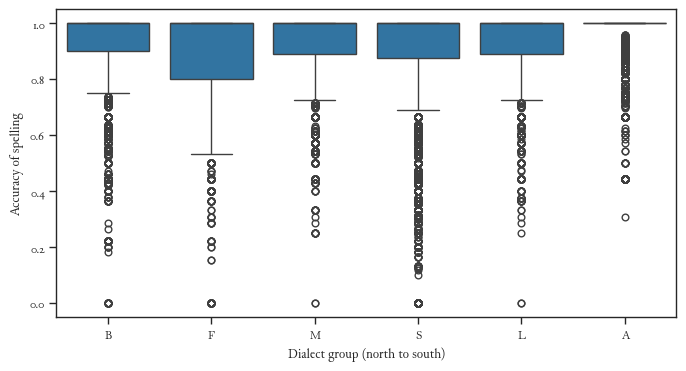

In [29]:
sns.boxplot(df_attestations, y="accuracy", x="dialect_group")
#sns.despine(trim=True)
plt.xlabel("Dialect group (north to south)")
plt.ylabel("Accuracy of spelling")
write_figure("accuracy_by_dialect")

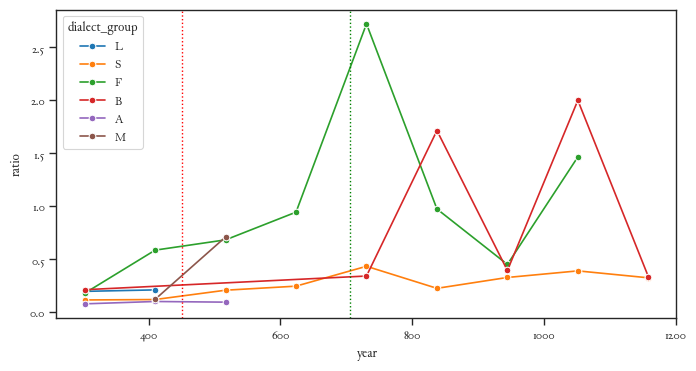

In [30]:
plot_data = []
for dialect_group in df_diff["dialect_group"].unique():
    dialect_subset = df_diff[(df_diff["dialect_group"] == dialect_group)]

    dates = dialect_subset['date_approximate'].dropna()

        # Histogram
    counts, _ = np.histogram(dates, bins=bins)
    ratio = counts / full_counts_per_dialect[dialect_group]
    
    # Collect results
    for x, y in zip(bin_centers, ratio):
        plot_data.append({
            'year': x,
            'ratio': y,
            'dialect_group': dialect_group,
        })

plot_df = pd.DataFrame(plot_data).replace(0, np.nan)
ax = sns.lineplot(plot_df, x="year", y="ratio", hue="dialect_group", marker='o')
#plt.ylabel("Greek attestations incorrectly (de-)aspirated (percent)")
#plt.xlabel("Year")
add_external_history(ax)
#write_figure("aspiration_by_dialect")
plt.show()

# Grouping deviations

In [31]:
consonants = set("ⲡ ⲧ ⲕ ⲃ ⲇ ⲅ ⲫ ⲑ ⲭ ϩ ⲥ ϣ ϥ ϫ ϭ ⲗ ⲣ ⳉ ϧ ⲛ ⲙ ⲍ ⲝ ⲯ".split())
vowels = set("ⲁ ⲉ ⲏ ⲓ ⲟ ⲱ ⲩ".split())
diphthongs = set("ⲁⲓ ⲉⲓ ⲏⲓ ⲟⲓ ⲱⲓ ⲁⲩ ⲉⲩ ⲟⲩ".split())

morphological_lapsus = {"∅→ⲥ", "∅→ⲓ", "∅→", "∅→", "∅→ⲏ", "∅→ⲕ", "∅→ⲧ", "∅→ⲡ", "∅→ⲣ", "∅→ⲟⲥ", "∅→ⲟⲩ", "ⲏ→ⲁ"}

deviation_operates_in = lambda graphemes: lambda deviation: deviation["norm"] in graphemes and deviation["var"] in graphemes

def classify(deviation):
    norm, var = deviation["norm"], deviation["var"]
    operates_in = lambda graphemes: deviation_operates_in(graphemes)(deviation)
    if operates_in({"ⲧ", "ⲇ"}) or operates_in({"ⲕ", "ⲅ"}) or operates_in({"ⲃ", "ⲡ"}) or operates_in({"ⲥ", "ⲍ"}):
        return "voiced_voiceless", "egyptian"
    elif operates_in({"ⲗ", "ⲣ"}):
        return "lambdacism", "egyptian"
    elif operates_in({"ⲧ", "ⲑ"}) or operates_in({"ⲫ", "ⲡ"}) or operates_in({"ⲭ", "ⲕ"}):
        return "voiceless_aspirated", "egyptian"
    elif operates_in({"∅", "ϩ"}):
        return "aspiration", "greek"
    elif operates_in({"ⲁⲓ", "ⲉ"}) or operates_in({"ⲱ", "ⲱⲓ"}) or operates_in({"ⲏⲓ", "ⲏ"}) or operates_in({"ⲏⲓ", "ⲓ"}) or operates_in({"ⲟⲓ", "ⲩ"}):
        return "monophthongization", "greek"
    elif operates_in({"ⲟ", "ⲱ"}) or operates_in({"ⲉⲓ", "ⲓ"}):
        return "isochrony", "greek"
    elif operates_in({"ⲉⲓ", "ⲏ"}) or operates_in({"ⲏ", "ⲓ"}):
        return "itacism", "greek"
    elif operates_in({"ⲩ", "ⲉⲓ"}) or operates_in({"ⲩ", "ⲏ"}) or operates_in({"ⲩ", "ⲓ"}) or operates_in({"ⲩ", "ⲟⲩ"}) or operates_in({"ⲟⲓ", "ⲉⲓ"}) or operates_in({"ⲟⲓ", "ⲓ"}) or operates_in({"ⲟⲓ", "ⲟⲩ"}):
        return "y-underdifferentiation", "egyptian"
    elif operates_in({"ⲓ", "ⲉ"}) or operates_in({"ⲏ", "ⲉ"}) or operates_in({"ⲩ", "ⲉ"}) or operates_in({"ⲟ", "ⲉ"}) or operates_in({"ⲟ", "ⲁ"}) or operates_in({"ⲟ", "ⲟⲩ"}):
        return "vowel_reduction", "egyptian"
    elif operates_in({"ⲑ", "ⲥ", "ⲇ"}) or operates_in({"ⲧ", "ⲑ"}) or operates_in({"ⲭ", "ⲕ", "ⲅ"}) or operates_in({"ⲭ", "ϩ", "ϧ", "ⲅ"}):
        return "late_aspirates", "egyptian"
    #elif operates_in({"ⲟⲓ", "ⲉ"}) or operates_in({"ⲁⲓ", "ⲁ"}) or operates_in({"ⲩⲓ", "ⲩ"}):
    #    return "monophthongization", "nongreek"
    #elif operates_in({"ⲟ", "ⲱ", "ⲟⲩ", "ⲱⲓ"}) or operates_in({"ⲁ", "ⲟ"}): # ôi ~ ô already attributed to monophthongisation
    #    return "back_vowel", "nongreek"
    #elif operates_in({"ⲏ", "ⲉ", "ⲩ", "ⲉⲓ", "ⲓ", "ⲟⲓ", "ⲁⲓ"}) or operates_in({"ⲁ", "ⲉ"}): # ai/oi ~ e already attributed to monophthongisation
    #    return "front_vowel", "nongreek"
    elif operates_in({"ⲅ", "ⲛ", "ⲙ"}) or operates_in({"ⲡⲥ", "ⲯ"}) or operates_in({"ⲕⲥ", "ⲝ"}):
        return "spelling", "greek"
    elif operates_in({"ⲛ", "∅"}) or operates_in({"ⲙ", "∅"}):
        return "nasal", "egyptian"
    elif operates_in({"ⲅ", "ϭ"}) or operates_in({"ⲭ", "ϭ"}) or operates_in({"ⲕ", "ϭ"}) or operates_in({"ϩ", "ϣ", "ϫ"}) or operates_in({"ⲭ", "ϫ"}):
        return "palatalisation", "egyptian"
    elif norm == 2 * var or var == 2 * norm:
        return "gemination", "greek"
    elif norm == "∅" and var in vowels | diphthongs:
        return "epenthesis", "egyptian"
    elif var == "∅" and norm in vowels | diphthongs:
        return "syncope", "egyptian"
    
    #elif norm == "ⲟ" and var == "ⲉ":
    #    return "reduction", "nongreek"
    #elif operates_in({"ϥ", "ⲃ"}):
    #    return "spirantisation", "egyptian"
    elif (norm in consonants and var in consonants) or (norm in vowels and var in vowels):
        return None, None #"other"
    else:
        return None, None

df_diff[["shift_class", "shift_origin"]] = df_diff.apply(classify, axis=1, result_type='expand')

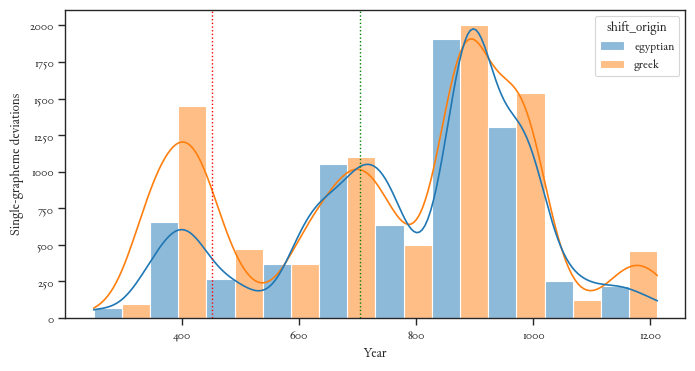

In [32]:
ax = sns.histplot(df_diff, x="date_approximate", hue="shift_origin", multiple="dodge", kde=True, bins=number_of_bins)
add_external_history(ax)
plt.xlabel("Year")
plt.ylabel("Single-grapheme deviations")
write_figure("greek_non_greek")

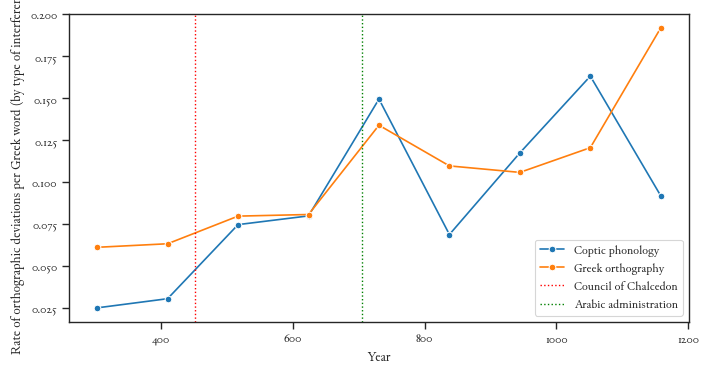

In [33]:
plot_data = []

# Iterate over each combination of norm and realization
for shift_origin in df_diff["shift_origin"].unique():
    origin_subset = df_diff[df_diff["shift_origin"] == shift_origin]

    dates = origin_subset['date_approximate'].dropna()

    # Histogram
    counts, _ = np.histogram(dates, bins=bins)
    ratio = counts / full_counts_safe
    # Collect results
    for x, y in zip(bin_centers, ratio):
        plot_data.append({
            'year': x,
            'ratio': y,
            'Type of interference': "Greek orthography" if shift_origin == "greek" else "Coptic phonology" if shift_origin == "egyptian" else None,
        })

plot_df = pd.DataFrame(plot_data)
ax = sns.lineplot(plot_df, hue="Type of interference", x="year", y="ratio", marker='o')
add_external_history(ax)
plt.ylabel("Rate of orthographic deviations per Greek word (by type of interference)")
plt.xlabel("Year")
plt.legend()
write_figure("attestations_by_deviations_origin")
plt.show()

In [34]:
df_diff[df_diff["shift_origin"] == "other"][["norm", "var"]].value_counts()

Series([], Name: count, dtype: int64)

### Statistical Prerequisites: Regularity

We define the *regularity* of an orthographic deviation to be its absolute frequency (how often it did appear) divided by the frequency with which the input appears in all Greek lemmata (how often it *could* appear).

Note that the *regularity* of an insertion is undefined. We cannot count the frequency of its input, i.e. the empty string.

# What influences (de-)geminations?

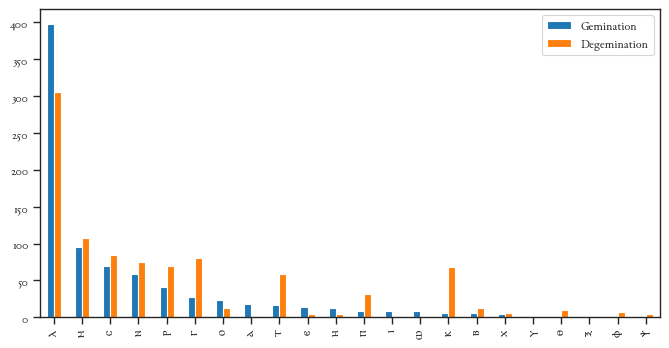

In [35]:
geminations = df_diff[(df_diff["norm"] * 2 == df_diff["var"])]
degeminations = df_diff[(df_diff["norm"] == df_diff["var"] * 2)]

interesting = vowels | consonants

geminate_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x * 2).sum() for x in interesting})

gemination_occurrences = geminations[geminations["norm"].isin(interesting)]["norm"].value_counts()
degemination_occurrences = degeminations[degeminations["var"].isin(interesting)]["var"].value_counts()

pd.DataFrame({
    "Gemination": gemination_occurrences,
    "Degemination": degemination_occurrences,
}).sort_values(by="Gemination", ascending=False).plot.bar()
write_figure("gemination_degemination")

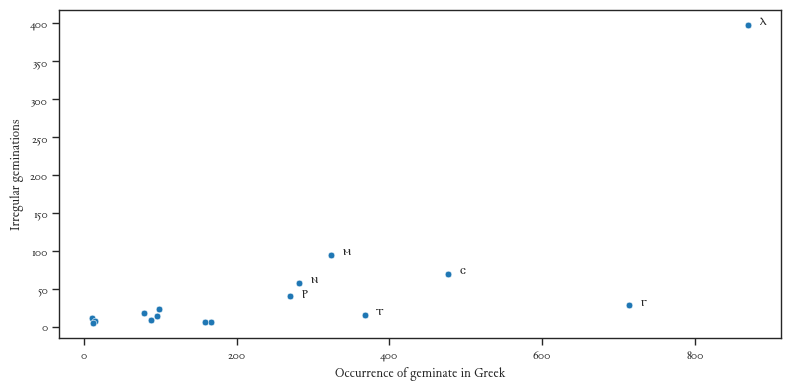

In [36]:
degemination_vs_geminates = pd.DataFrame({
    "Degemination": degemination_occurrences,
    "Geminates": geminate_occurrences,
    "Gemination": gemination_occurrences,
}).dropna()
ax = sns.scatterplot(degemination_vs_geminates, y="Gemination", x="Geminates")
plt.ylabel("Irregular geminations")
plt.tight_layout()
plt.xlabel("Occurrence of geminate in Greek")
for key, x in degemination_vs_geminates.iterrows():
    if any([n>=200 for n in x]):
        ax.text(x=x["Geminates"] + 15, y=x["Gemination"], s=key)
write_figure("geminations_geminates")
#plt.yscale("log")
stat_geminations_geminates = scipy.stats.spearmanr(degemination_vs_geminates["Geminates"], degemination_vs_geminates["Gemination"])
write_json(stat_geminations_geminates, "geminations_geminates")

## Is Bohairic different?

In [37]:
x_gem = geminations[geminations["norm"].isin(interesting)]
x_deg = degeminations[degeminations["var"].isin(interesting)]

x_gem_deg = pd.concat([x_gem, x_deg])

#pd.crosstab(x_gem_deg["deviation"], x_gem_deg["dialect_group"]).sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)
xtab_gem = pd.crosstab(df_diff.shift_class == "gemination", df_diff.dialect_group == "B").rename(
    columns={
        True: 'B',  # Rename True to 'Group B'
        False: 'F/M/S/L/A'    # Rename False to 'Other'
    },
    index={
        True: 'Gemination deviation',  # Rename True to 'Aspiration & Non-Greek'
        False: 'Other deviation'        # Rename False to 'Other Combinations'
    }
)

stats_gem = contingency_statistics(xtab_gem)

write_json(stats_gem, "dialect_gemination")
write_csv(xtab_gem, "dialect_gemination")

print(stats_gem)
xtab_gem

{'chi^2': 0.058748054076303576, 'p': 0.8084857466052262, 'df': 1, 'V': 0.0013956622830883449}


dialect_group,F/M/S/L/A,B
shift_class,,
Other deviation,40115,2439
Gemination deviation,1713,101


# Vowel alternations

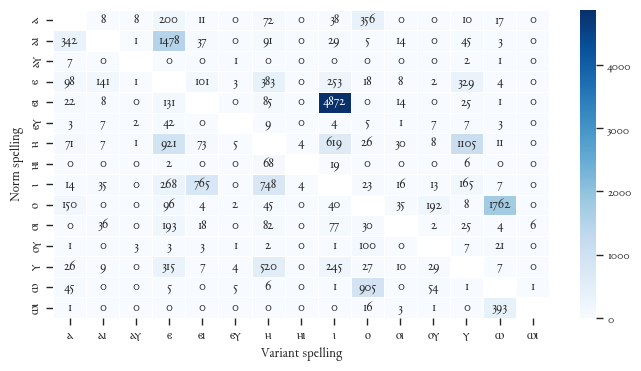

In [38]:
df_diff_vocalic = df_diff[df_diff["norm"].isin(vowels | diphthongs) & df_diff["var"].isin(vowels | diphthongs)]
vowel_frequency_data = pd.crosstab(df_diff_vocalic["norm"], df_diff_vocalic["var"])

unique_labels = list(set(vowel_frequency_data.index).union(set(vowel_frequency_data.columns)))

vowel_frequency = pd.DataFrame(0, index=unique_labels, columns=unique_labels).sort_index().sort_index(axis=1)

vowel_frequency.update(vowel_frequency_data)

write_csv(vowel_frequency, "vowel_frequency")

np.fill_diagonal(vowel_frequency.values, -1)
sns.heatmap(vowel_frequency, cmap=cm, annot=True, linewidth=0.5, fmt="d", mask=(vowel_frequency == -1))
plt.xlabel("Variant spelling")
plt.ylabel("Norm spelling")
write_figure("vowel_frequency")

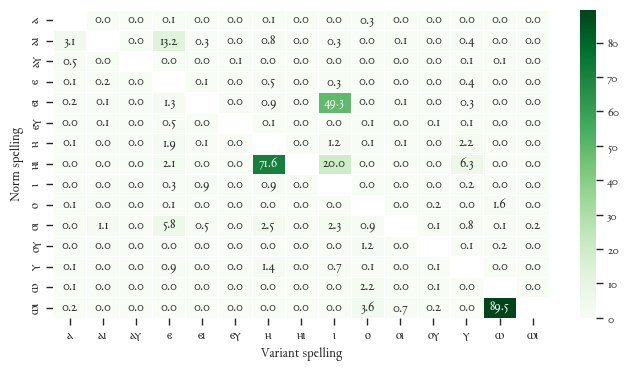

In [39]:
vowel_occurrences = pd.Series({x: df_attestations["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs})

vowel_regularity = 100 * vowel_frequency.div(vowel_occurrences, axis="rows").fillna(0)
write_csv(vowel_regularity, "vowel_regularity")

np.fill_diagonal(vowel_regularity.values, -1)
sns.heatmap(vowel_regularity, annot=True, fmt=".1f", linewidth=0.5, cmap="Greens", mask=(vowel_regularity == -1))
plt.xlabel("Variant spelling")
plt.ylabel("Norm spelling")
write_figure("vowel_regularity")

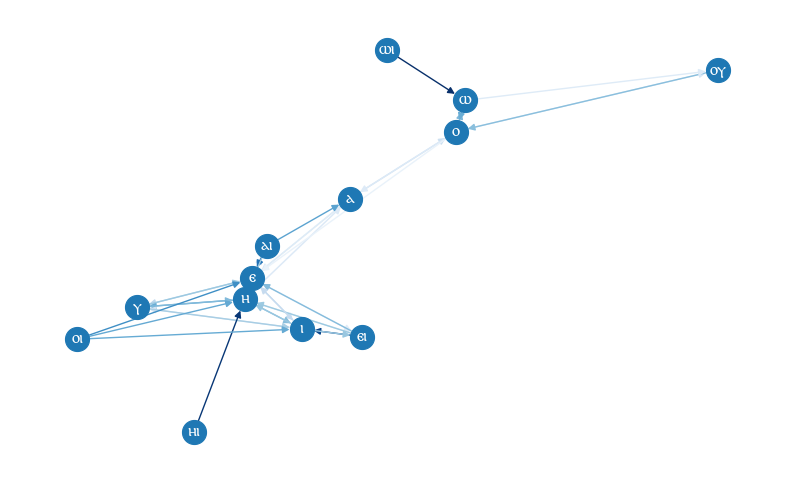

In [40]:
all_vowel_regularities = vowel_regularity.stack().reset_index().rename(columns={"level_0": "norm", "level_1": "var", 0: "regularity"})
all_vowel_frequencies = vowel_frequency.stack().reset_index().rename(columns={"level_0": "norm", "level_1": "var", 0: "frequency"})
vowel_deviations = pd.merge(all_vowel_regularities, all_vowel_frequencies, on=["norm", "var"])

fig = plt.figure(figsize=(10, 6))

graph = nx.from_pandas_edgelist(
    vowel_deviations[vowel_deviations["frequency"] >= 50],
    source="norm",
    target="var",
    edge_attr=["regularity", "frequency"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, weight="frequency", seed=6)

nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(v) for v in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)

fig.savefig(subdirectory / "figure-vowels_graph.svg")
plt.show()

/tmp/nix-shell.wTW14Y/ipykernel_2124977/56228725.py:13: RuntimeWarning: invalid value encountered in sqrt
  distance_matrix = 1 - sym_norm_confusion.values ** 0.5


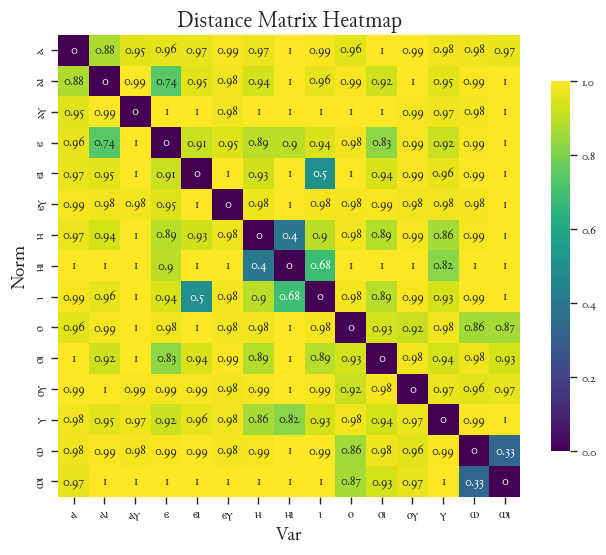

/tmp/nix-shell.wTW14Y/ipykernel_2124977/56228725.py:35: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


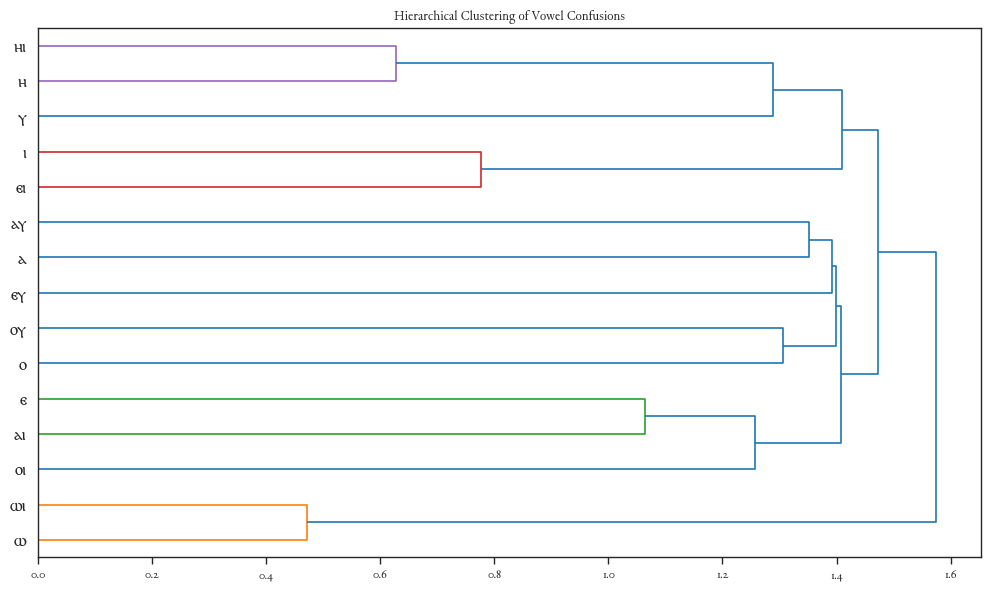

In [41]:
# Make a copy to avoid modifying original
norm_confusion = vowel_frequency.copy().astype(float)

# Normalize each row by its total occurrence count
for grapheme in norm_confusion.index:
    if grapheme in vowel_occurrences:
        total = vowel_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)

# Fill the diagonal with 0
np.fill_diagonal(distance_matrix, 0)

# Option 1: Update the DataFrame directly
distance_df.iloc[:, :] = distance_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)

# Show the plot
plt.show()

from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Vowel Confusions")
plt.tight_layout()
plt.show()


In [42]:
front_vowel_list = ["ⲓ", "ⲩ", "ⲟⲓ", "ⲏ", "ⲉ", "ⲁⲓ", "ⲟ", "ⲱ", "ⲁ"]
front_vowels = df_diff[df_diff["norm"].isin(front_vowel_list)].copy()
front_vowels["realization"] = front_vowels["var"].apply(lambda x: "ⲓ, ⲩ, ⲏ, ⲉⲓ, ⲟⲓ /i, y/" if x in {"ⲟⲓ", "ⲩ", "ⲏ", "ⲓ", "ⲉⲓ"} else "ⲉ, ⲁⲓ /e̞/" if x in {"ⲉ", "ⲁⲓ"} else "ⲟⲩ /u/" if x in {"ⲟⲩ"} else "ⲟ, ⲱ /o̞/" if x in {"ⲟⲩ", "ⲟ", "ⲱ"} else "ⲁ /a/" if x in {"ⲁ"} else None)

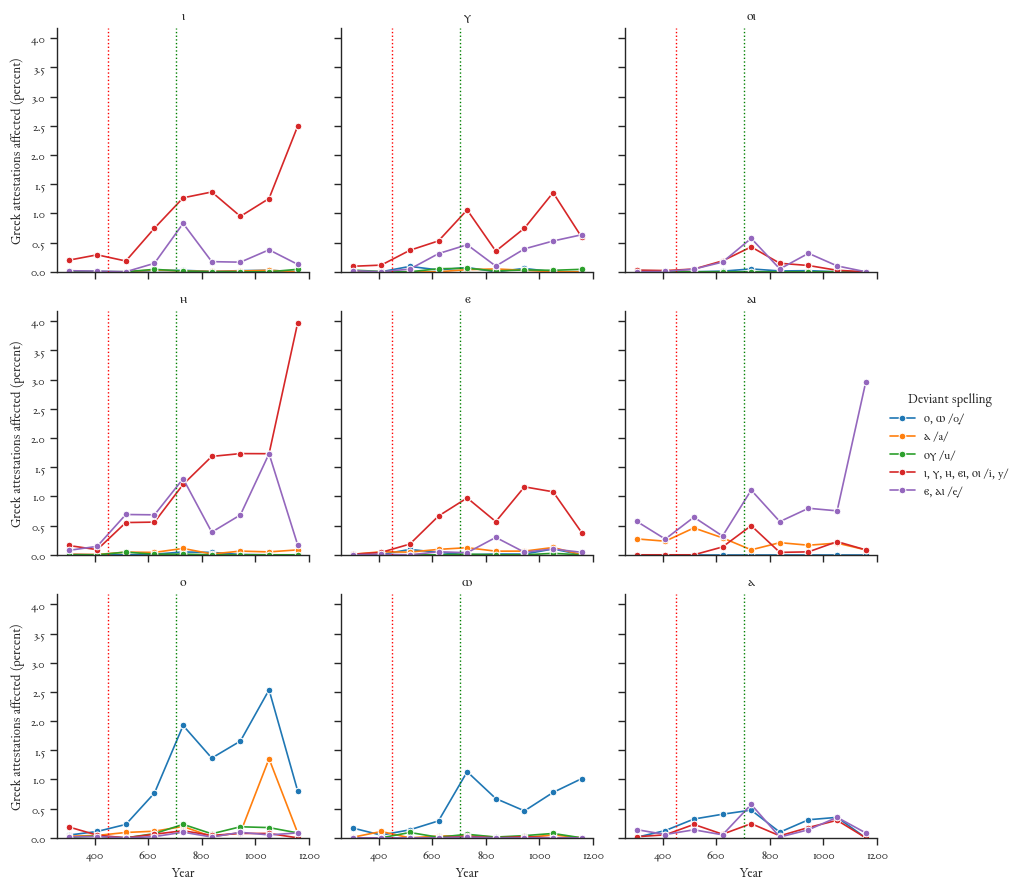

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_data = []

# Iterate over each combination of norm and realization
for norm_value in front_vowels["norm"].unique():
    norm_subset = front_vowels[front_vowels["norm"] == norm_value]

    for realization_value in norm_subset["realization"].dropna().unique():
        subset = norm_subset[norm_subset["realization"] == realization_value]
        dates = subset['date_approximate'].dropna()

        # Histogram
        counts, _ = np.histogram(dates, bins=bins)
        ratio = counts / full_counts_safe
        # Collect results
        for x, y in zip(bin_centers, ratio):
            plot_data.append({
                'year': x,
                'ratio': y * 100,
                'norm': norm_value,
                'realization': realization_value
            })

plot_df = pd.DataFrame(plot_data)

g = sns.FacetGrid(plot_df, col="norm", hue="realization", col_wrap=3, sharey=True, col_order=front_vowel_list)
g.map_dataframe(sns.lineplot, x="year", y="ratio", marker='o')
g.set(ylim=0)
g.set_axis_labels("Year", "Greek attestations affected (percent)")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Deviant spelling")

for ax in g.axes.flat:
    add_external_history(ax)

#plt.tight_layout()
#plt.legend()
plt.show()
g.savefig(subdirectory / "figure-vowels_by_year.svg")

In [44]:
import re

vowel_diphthong_regex = re.compile("|".join(list(diphthongs) + list(vowels)))
def count_vowels(text: str) -> int:
    if type(text) == str:
        matches = list(re.finditer(vowel_diphthong_regex, text.lower()))
        return len(matches)
    else:
        return None

syllables_right = df_diff.context_right.apply(count_vowels)
can_be_stressed = syllables_right <= 1

In [45]:
realization_class = lambda x: "i" if x in {"ⲉⲓ", "ⲓ", "ⲏ", "ⲩ", "ⲟⲓ", "ⲏⲓ"} else "e" if x in {"ⲉ", "ⲁⲓ"} else "o" if x in {"ⲟ", "ⲱ", "ⲱⲓ"} else "u" if x in {"ⲟⲩ"} else "a" if x in {"ⲁ"} else x

df_vowel_alternation = df_diff[df_diff["norm"].isin(vowels | diphthongs) & df_diff["var"].isin(vowels | diphthongs)].copy()
df_vowel_alternation["norm_class"] = df_vowel_alternation["norm"].apply(realization_class)
df_vowel_alternation["var_class"] = df_vowel_alternation["var"].apply(realization_class)
df_vowel_alternation["alternation"] = df_vowel_alternation.apply(lambda row: "→".join([row["norm_class"], row["var_class"]]), axis=1)
xtab_vowel_alternation = pd.crosstab(df_vowel_alternation["alternation"], can_be_stressed)

In [46]:
chi2_deluxe(xtab_vowel_alternation)

context_right,False,True
alternation,,
a→e,"–, χ² = 6.89 n. s.","+, χ² = 4.05 n. s."
a→i,"–, χ² = 0.88 n. s.","+, χ² = 0.52 n. s."
a→o,"–, χ² = 58.83 ***","+, χ² = 34.61 ***"
a→ⲁⲩ,"+, χ² = 1.40 n. s.","–, χ² = 0.82 n. s."
e→a,"–, χ² = 14.72 **","+, χ² = 8.66 n. s."
e→e,"+, χ² = 13.61 *","–, χ² = 8.00 n. s."
e→i,"+, χ² = 46.58 ***","–, χ² = 27.40 ***"
e→o,"+, χ² = 14.95 **","–, χ² = 8.79 n. s."
e→u,"+, χ² = 2.14 n. s.","–, χ² = 1.26 n. s."


unstressed_replacements = dict()
stressed_replacements = dict()

for vowel in vowels | diphthongs:
    def categorize(row):
        if row["norm"] == vowel and row["var"] in vowels | diphthongs:
            return row["var"]
        else:
            return "other"
        
    
    xtab_ai = pd.crosstab(df_diff.apply(categorize, axis=1), can_be_stressed)
    xtab_ai_deluxe = chi2_deluxe(xtab_ai)
    write_csv(xtab_ai_deluxe, "ai_contributions")
    xtab_ai_deluxe#.index
    
    unstressed_replacements[vowel] = list(xtab_ai_deluxe[xtab_ai_deluxe[False].str.contains(r"\+.*\*")].index)
    stressed_replacements[vowel] = list(xtab_ai_deluxe[xtab_ai_deluxe[True].str.contains(r"\+.+\*")].index)

xtab_ai

unstressed_replacements

stressed_replacements

def create_graph(data, title):
    G = nx.DiGraph()
    
    for key, values in data.items():
        for value in values:
            G.add_edge(key, value)
    
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=2000, node_color='lightblue', font_size=10, font_family="Antinoou", font_weight='bold')
    plt.title(title)
    plt.show()

# Create and display graphs
create_graph(unstressed_replacements, 'Unstressed Replacements Graph')
create_graph(stressed_replacements, 'Stressed Replacements Graph')


## Diphthongs

<Axes: xlabel='date_approximate', ylabel='Count'>

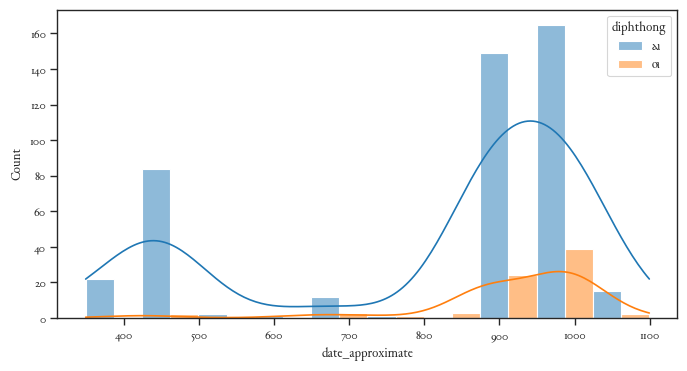

In [47]:
spelling_pronunciation = df_attestations[
    (df_attestations["greek_lemma"].str.contains("ⲟⲓ") & df_attestations["orthography"].str.contains("ⲟⲓ̈"))
    | (df_attestations["greek_lemma"].str.contains("ⲁⲓ") & df_attestations["orthography"].str.contains("ⲁⲓ̈"))
].copy()
spelling_pronunciation["diphthong"] = spelling_pronunciation["orthography"].apply(lambda x: "ⲟⲓ" if "ⲟⲓ̈" in x else "ⲁⲓ" if "ⲁⲓ̈" in x else "?")
sns.histplot(data=spelling_pronunciation, x='date_approximate', multiple="dodge", hue='diphthong', bins=number_of_bins, kde=True)

<https://kmein.github.io/greek-coptic-dashboard/?orthography_regex=%E2%B2%81%E2%B2%93%CC%88|%E2%B2%9F%E2%B2%93%CC%88&greek_lemma_regex=%E2%B2%81%E2%B2%93|%E2%B2%9F%E2%B2%93>

In [48]:
spelling_pronunciation.sample(10)["orthography"]

157415        ⲗⲟⲓ̈ⲡⲟⲛ
119976          ⲁⲓ̈ⲱⲛ
119135         ⲭⲁⲓ̈ⲣⲉ
153194       ⲓ̈ⲟⲩⲇⲁⲓ̈
142953     ϩⲁⲓ̈ⲣⲉϯⲕⲟⲥ
188482          ⲁⲓ̈ⲧⲓ
157203      ϩⲣⲱⲙⲁⲓ̈ⲟⲥ
119704      ⲙⲉⲧⲁⲛⲟⲓ̈ⲁ
127160    ⲁ|ⲛⲁⲅⲕⲁⲓ̈ⲟⲛ
84486        ⲁⲓ̈|ⲧⲓ̈ⲁ
Name: orthography, dtype: object

## Progressive spelling of ⲁⲓ/ⲉⲓ in Bohairic?

In [49]:
def categorize(row):
    if row['norm'] == "ⲁⲓ" and row['var'] == "ⲉ":
        return "ⲁⲓ → ⲉ"
    elif row['norm'] == "ⲉⲓ" and row['var'] == "ⲓ":
        return "ⲉⲓ → ⲓ"
    else:
        return "other"
        
xtab_ai_ei = pd.crosstab(
    df_diff.apply(categorize, axis=1),
    df_diff['dialect_group'].apply(lambda x: x if x in ["F", "B"] else "M/S/L/A")
)
stats_ai_ei = contingency_statistics(xtab_ai_ei)


write_csv(xtab_ai_ei, "progressive_ai_ei")
write_json(stats_ai_ei, "progressive_ai_ei")

print(stats_ai_ei)
xtab_ai_ei

{'chi^2': 1069.8719931207074, 'p': 2.566619267505719e-230, 'df': 4, 'V': 0.10980344992077848}


dialect_group,B,F,M/S/L/A
row_0,,,
other,1874,1812,34332
ⲁⲓ → ⲉ,339,174,965
ⲉⲓ → ⲓ,327,187,4358


In [50]:
xtab_ai_ei_deluxe = chi2_deluxe(xtab_ai_ei)
write_csv(xtab_ai_ei_deluxe, "progressive_ai_ei_contributions")
xtab_ai_ei_deluxe

dialect_group,B,F,M/S/L/A
row_0,,,
other,"–, χ² = 42.04 ***","–, χ² = 1.34 n. s.","+, χ² = 3.66 n. s."
ⲁⲓ → ⲉ,"+, χ² = 764.81 ***","+, χ² = 142.64 ***","–, χ² = 95.94 ***"
ⲉⲓ → ⲓ,"+, χ² = 8.29 *","–, χ² = 11.16 **","+, χ² = 0.00 n. s."


## What influences ⲁ-vowel deviation?

In [51]:
def categorize(row):
    if row['norm'] in {"ⲁ", "ⲟ"} and row['var'] in {"ⲁ", "ⲟ"}:
        return "ⲁ/ⲟ"
    elif row['norm'] == "ⲉ" and row['var'] in {"ⲁ", "ⲉ"}:
        return "ⲉ/ⲁ"
    else:
        return "other"
        
xtab_vocalism = pd.crosstab(
    df_diff.apply(categorize, axis=1),
    df_diff['dialect_group'].isin({"F", "L", "A"})
).rename(
    columns={False: "S/B", True: "F/M/L/A"}
)

stats_vocalism = contingency_statistics(xtab_vocalism)


write_csv(xtab_vocalism, "progressive_vocalism")
write_json(stats_vocalism, "progressive_vocalism")

print(stats_vocalism)
xtab_vocalism

{'chi^2': 29.058559553529182, 'p': 4.897945709221946e-07, 'df': 2, 'V': 0.025591875542752534}


dialect_group,S/B,F/M/L/A
row_0,,
other,39538,4226
ⲁ/ⲟ,493,13
ⲉ/ⲁ,88,10


In [52]:
xtab_vocalism_deluxe = chi2_deluxe(xtab_vocalism)
write_csv(xtab_vocalism_deluxe, "progressive_vocalism_contributions")
xtab_vocalism_deluxe

dialect_group,S/B,F/M/L/A
row_0,,
other,"–, χ² = 0.03 n. s.","+, χ² = 0.29 n. s."
ⲁ/ⲟ,"+, χ² = 2.75 n. s.","–, χ² = 25.95 ***"
ⲉ/ⲁ,"–, χ² = 0.00 n. s.","+, χ² = 0.04 n. s."


## Coarticulation

In [53]:
def place_of_articulation(x):
    if x in {"ⲃ", "ⲡ", "ⲫ", "ⲙ", "ⲯ"}:
        return "labial"
    elif x in {"ⲅ", "ⲕ", "ⲭ", "ⲝ"}:
        return "velar"
    elif x in {"ⲇ", "ⲧ", "ⲑ", "ⲗ", "ⲛ", "ⲣ", "ⲥ", "ⲍ"}:
        return "alveolar"
    else:
        return None


def compare_vowels(vowel1, vowel2, strata):
    # Create a mapping of vowels to their stratum index
    stratum_index = {vowel: index for index, stratum in enumerate(strata) for vowel in stratum}
    
    # Get the indices of the vowels
    index1 = stratum_index.get(vowel1)
    index2 = stratum_index.get(vowel2)
    
    # Compare the indices
    if index1 is None or index2 is None:
        return None  # Return None if one or both vowels are not found
    elif index1 < index2:
        return -1  # vowel1 is in an earlier stratum
    elif index1 > index2:
        return +1  # vowel1 is in a later stratum
    else:
        return 0  # Both vowels are in the same stratum

# assuming early koine inventory
vowel_height = [["ⲓ", "ⲉⲓ", "ⲟⲩ", "ⲏ", "ⲟⲓ", "ⲩ"], ["ⲁⲓ", "ⲉ", "ⲟ", "ⲱ"], ["ⲁ"]]
vowel_frontness = [["ⲓ", "ⲉⲓ", "ⲩ", "ⲟⲓ", "ⲏ"], ["ⲁⲓ", "ⲉ"], ["ⲁ"], ["ⲟ", "ⲱ"], ["ⲟⲩ"]]
vowel_roundness = [["ⲓ", "ⲉⲓ", "ⲏ", "ⲁⲓ", "ⲉ", "ⲁ"], ["ⲩ", "ⲟⲓ", "ⲟ", "ⲟⲩ", "ⲱ"]]

def process_height(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_height)
    if comparison is not None:
        if comparison < 0:
            return "lowering"
        elif comparison > 0:
            return "raising"
        else:
            #print(comparison, row["norm"], row["var"])
            return "none"

def process_frontness(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_frontness)
    if comparison is not None:
        if comparison < 0:
            return "backing"
        elif comparison > 0:
            return "fronting"
        else:
            return "none"

def process_roundness(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_roundness)
    if comparison is not None:
        if comparison < 0:
            return "unrounding"
        elif comparison > 0:
            return "rounding"
        else:
            return "none"

x = df_diff[(df_diff["norm"].isin(vowels|diphthongs)) & df_diff["var"].isin(vowels | diphthongs) & (df_diff["context_right"] != "#")].copy()
x["environment_left"] = x.apply(lambda row: place_of_articulation(row.context_left[-1]), axis=1)
x["environment_right"] = x.apply(lambda row: place_of_articulation(row.context_right[0]), axis=1)
x["environment"] = x["environment_left"] + "…" + x["environment_right"]


In [54]:
x["coarticulation_height"] = x.apply(process_height, axis=1).astype('category').cat.reorder_categories(['none', 'lowering', 'raising'], ordered=False)
x["coarticulation_frontness"] = x.apply(process_frontness, axis=1).astype('category').cat.reorder_categories(['none', 'backing', 'fronting'], ordered=False)
x["coarticulation_roundness"] = x.apply(process_roundness, axis=1)
x["velar_adjacent"] = (x["environment_right"] == "velar") | (x["environment_left"] == "velar")
x["alveolar_adjacent"] = (x["environment_right"] == "alveolar") | (x["environment_left"] == "alveolar")
x["labial_adjacent"] = (x["environment_right"] == "labial") | (x["environment_left"] == "labial")
x

,id,norm,var,context_left,context_right,greek_lemma,greek_lemma_original,orthography,orthography_clean,dialect,...,shift_origin,environment_left,environment_right,environment,coarticulation_height,coarticulation_frontness,coarticulation_roundness,velar_adjacent,alveolar_adjacent,labial_adjacent
5,71678,ⲉⲓ,ⲓ,ⲭⲣ,ⲁ,ⲭⲣⲉⲓⲁ,χρεία,ⲭⲣⲓⲁ,ⲭⲣⲓⲁ,L5,...,greek,alveolar,None,NaN,none,none,none,False,True,False
23,72537,ⲉⲓ,ⲓ,ⲡ,ⲣⲁⲍⲱ,ⲡⲉⲓⲣⲁⲍⲱ,πειράζω,ⲡⲓⲣⲁⲍⲉ,ⲡⲓⲣⲁⲍⲉ,L5,...,greek,labial,alveolar,labial…alveolar,none,none,none,False,True,True
39,73321,ⲉⲓ,ⲓ,ⲡⲟⲣⲛ,ⲁ,ⲡⲟⲣⲛⲉⲓⲁ,πορνεία,ⲡ[οⲣ]ⲛⲓⲁ,ⲡⲟⲣⲛⲓⲁ,L5,...,greek,alveolar,None,NaN,none,none,none,False,True,False
54,73457,ⲟⲓ,ⲩ,ⲡⲁⲣ,ⲙⲓⲁ,ⲡⲁⲣⲟⲓⲙⲓⲁ,παροιμία,ⲡⲁⲣϩⲩⲙⲓⲁ,ⲡⲁⲣϩⲩⲙⲓⲁ,L5,...,greek,alveolar,labial,alveolar…labial,none,none,none,False,True,True
78,73720,ⲉⲓ,ⲓ,ⲇ,ⲡⲛⲟⲛ,ⲇⲉⲓⲡⲛⲟⲛ,δεῖπνον,ⲇⲓ[ⲡⲛⲟⲛ],ⲇⲓⲡⲛⲟⲛ,L5,...,greek,alveolar,labial,alveolar…labial,none,none,none,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44349,201043,ⲁ,ⲟ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣ,ⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲁⲥ,μανδραγόρας,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,S,...,egyptian,alveolar,alveolar,alveolar…alveolar,raising,backing,unrounding,False,True,False
44350,201044,ⲁ,ⲟ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣ,ⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲁⲥ,μανδραγόρας,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,S,...,egyptian,alveolar,alveolar,alveolar…alveolar,raising,backing,unrounding,False,True,False
44351,201045,ⲁ,ⲟ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣ,ⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲁⲥ,μανδραγόρας,[ⲙ]ⲁⲛⲇⲣⲁⲅⲟⲣ[ⲟⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,S,...,egyptian,alveolar,alveolar,alveolar…alveolar,raising,backing,unrounding,False,True,False
44352,201046,ⲁ,ⲟ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣ,ⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲁⲥ,μανδραγόρας,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,S,...,egyptian,alveolar,alveolar,alveolar…alveolar,raising,backing,unrounding,False,True,False


### Raising / Lowering

In [55]:
xtab_rhotic_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲣ"})) | (x["context_right"].str[0].isin({"ⲣ"})), x.apply(process_height, axis=1)).rename(
    index={True: "rhotic environment", False: "non-rhotic environment"}
)
print(contingency_statistics(xtab_rhotic_coarticulation))
xtab_rhotic_coarticulation

{'chi^2': 68.60647985738782, 'p': 1.2655875316050132e-15, 'df': 2, 'V': 0.06155953034648383}


col_0,lowering,none,raising
row_0,,,
non-rhotic environment,1861,10504,1529
rhotic environment,691,2916,603


In [56]:
chi2_deluxe(xtab_rhotic_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-rhotic environment,"–, χ² = 4.86 n. s.","+, χ² = 4.07 n. s.","–, χ² = 7.03 *"
rhotic environment,"+, χ² = 16.03 ***","–, χ² = 13.43 **","+, χ² = 23.18 ***"


In [57]:
xtab_nasal_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲙ", "ⲛ"})), x.apply(process_height, axis=1)).rename(
    index={True: "after nasal", False: "after non-nasal"}
)
print(contingency_statistics(xtab_nasal_coarticulation))
xtab_nasal_coarticulation

{'chi^2': 275.4132345296325, 'p': 1.5659431822565783e-60, 'df': 2, 'V': 0.123340337478885}


col_0,lowering,none,raising
context_left,,,
after non-nasal,2035,11926,1676
after nasal,517,1494,456


In [58]:
chi2_deluxe(xtab_nasal_coarticulation)

col_0,lowering,none,raising
context_left,,,
after non-nasal,"–, χ² = 12.99 **","+, χ² = 9.67 *","–, χ² = 14.87 ***"
after nasal,"+, χ² = 82.37 ***","–, χ² = 61.27 ***","+, χ² = 94.25 ***"


In [59]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_height, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'chi^2': 116.60384668293214, 'p': 4.7840576940999593e-26, 'df': 2, 'V': 0.08025445842954732}


col_0,lowering,none,raising
row_0,,,
non-velar environment,2045,9962,1413
velar environment,507,3458,719


In [60]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-velar environment,"+, χ² = 12.42 **","+, χ² = 0.02 n. s.","–, χ² = 17.73 ***"
velar environment,"–, χ² = 35.58 ***","–, χ² = 0.06 n. s.","+, χ² = 50.80 ***"


In [61]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_height, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'chi^2': 100.94218223832837, 'p': 1.204158432524131e-22, 'df': 2, 'V': 0.07467050254562266}


col_0,lowering,none,raising
row_0,,,
non-labial environment,1453,9012,1363
labial environment,1099,4408,769


In [62]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-labial environment,"–, χ² = 27.55 ***","+, χ² = 6.80 n. s.","–, χ² = 0.64 n. s."
labial environment,"+, χ² = 51.92 ***","–, χ² = 12.82 **","+, χ² = 1.21 n. s."


In [63]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_height, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'chi^2': 219.3274901360833, 'p': 2.3639628763397313e-48, 'df': 2, 'V': 0.11006754096271754}


col_0,lowering,none,raising
row_0,,,
non-alveolar environment,341,2674,169
alveolar environment,2211,10746,1963


In [64]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-alveolar environment,"–, χ² = 25.90 ***","+, χ² = 41.72 ***","–, χ² = 113.13 ***"
alveolar environment,"+, χ² = 5.53 n. s.","–, χ² = 8.90 *","+, χ² = 24.14 ***"


### Fronting / Backing

In [65]:
xtab_rhotic_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲣ"})) | (x["context_right"].str[0].isin({"ⲣ"})), x.apply(process_frontness, axis=1)).rename(
    index={True: "rhotic environment", False: "non-rhotic environment"}
)
print(contingency_statistics(xtab_rhotic_coarticulation))
xtab_rhotic_coarticulation

{'chi^2': 73.25098430119847, 'p': 1.2409402238137253e-16, 'df': 2, 'V': 0.06360913092271563}


col_0,backing,fronting,none
row_0,,,
non-rhotic environment,2052,1489,10353
rhotic environment,839,492,2879


In [66]:
chi2_deluxe(xtab_rhotic_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-rhotic environment,"–, χ² = 12.53 **","–, χ² = 0.65 n. s.","+, χ² = 3.86 n. s."
rhotic environment,"+, χ² = 41.34 ***","+, χ² = 2.13 n. s.","–, χ² = 12.75 **"


In [67]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_frontness, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'chi^2': 29.09706146156228, 'p': 4.804557373000619e-07, 'df': 2, 'V': 0.040090114371286366}


col_0,backing,fronting,none
row_0,,,
non-velar environment,2211,1380,9829
velar environment,680,601,3403


In [68]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-velar environment,"+, χ² = 2.16 n. s.","–, χ² = 5.33 n. s.","+, χ² = 0.04 n. s."
velar environment,"–, χ² = 6.18 n. s.","+, χ² = 15.27 ***","–, χ² = 0.12 n. s."


In [69]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_frontness, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'chi^2': 127.01483294022509, 'p': 2.624698766187987e-28, 'df': 2, 'V': 0.08376063289168917}


col_0,backing,fronting,none
row_0,,,
non-labial environment,1635,1265,8928
labial environment,1256,716,4304


In [70]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-labial environment,"–, χ² = 34.10 ***","–, χ² = 0.66 n. s.","+, χ² = 9.27 *"
labial environment,"+, χ² = 64.27 ***","+, χ² = 1.25 n. s.","–, χ² = 17.47 ***"


In [71]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_frontness, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'chi^2': 165.76399893887893, 'p': 1.0111253093943911e-36, 'df': 2, 'V': 0.09568807926841566}


col_0,backing,fronting,none
row_0,,,
non-alveolar environment,359,208,2617
alveolar environment,2532,1773,10615


In [72]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-alveolar environment,"–, χ² = 43.93 ***","–, χ² = 56.58 ***","+, χ² = 36.10 ***"
alveolar environment,"+, χ² = 9.37 *","+, χ² = 12.07 **","–, χ² = 7.70 *"


### Rounding / unrounding

In [73]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_roundness, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'chi^2': 218.7336644441391, 'p': 3.181180141560343e-48, 'df': 2, 'V': 0.10991843691163236}


col_0,none,rounding,unrounding
row_0,,,
non-velar environment,10691,1384,1345
velar environment,3304,545,835


In [74]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-velar environment,"+, χ² = 9.68 *","–, χ² = 1.47 n. s.","–, χ² = 45.44 ***"
velar environment,"–, χ² = 27.73 ***","+, χ² = 4.22 n. s.","+, χ² = 130.18 ***"


In [75]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_roundness, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'chi^2': 182.53195152245877, 'p': 2.310416840142042e-40, 'df': 2, 'V': 0.10041120479679475}


col_0,none,rounding,unrounding
row_0,,,
non-labial environment,9501,1059,1268
labial environment,4494,870,912


In [76]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-labial environment,"+, χ² = 13.98 **","–, χ² = 32.15 ***","–, χ² = 17.15 ***"
labial environment,"–, χ² = 26.35 ***","+, χ² = 60.59 ***","+, χ² = 32.31 ***"


In [77]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_roundness, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'chi^2': 50.48671784771151, 'p': 1.0888010090171554e-11, 'df': 2, 'V': 0.05280819197455745}


col_0,none,rounding,unrounding
row_0,,,
non-alveolar environment,2533,382,269
alveolar environment,11462,1547,1911


In [78]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-alveolar environment,"+, χ² = 2.09 n. s.","+, χ² = 5.38 n. s.","–, χ² = 34.14 ***"
alveolar environment,"–, χ² = 0.45 n. s.","–, χ² = 1.15 n. s.","+, χ² = 7.28 *"


# Consonant alternations

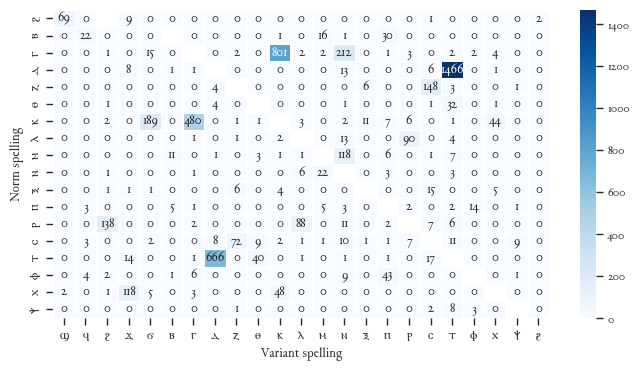

In [79]:
df_diff_consonantal = df_diff[df_diff["norm"].isin(consonants) & df_diff["var"].isin(consonants)]
consonant_frequency = pd.crosstab(df_diff_consonantal["norm"], df_diff_consonantal["var"])
consonant_frequency = consonant_frequency.loc[consonant_frequency.any(axis=1), consonant_frequency.any(axis=0)]
write_csv(consonant_frequency, "consonant_frequency")

unique_labels = list(set(consonant_frequency.index).union(set(consonant_frequency.columns)))
for i in unique_labels:
    if i in consonant_frequency.index and i in consonant_frequency.columns:
        consonant_frequency.loc[i, i] = -1


sns.heatmap(consonant_frequency, cmap=cm, annot=True, linewidth=0.5, fmt="d", mask=(consonant_frequency==-1))
plt.xlabel("Variant spelling")
plt.ylabel("Norm spelling")
write_figure("consonant_frequency")

In [80]:
pd.DataFrame(df_diff_consonantal.groupby(["norm", "var"])["date_approximate"].agg("median").unstack()).style.background_gradient(axis=None, cmap=cm)

var,ϣ,ϥ,ϩ,ϫ,ϭ,ⲃ,ⲅ,ⲇ,ⲍ,ⲑ,ⲕ,ⲗ,ⲙ,ⲛ,ⲝ,ⲡ,ⲣ,ⲥ,ⲧ,ⲫ,ⲭ,ⲯ,ⳉ
norm,,,,,,,,,,,,,,,,,,,,,,,
ϩ,–,–,–,349.50,–,–,–,–,–,–,–,–,–,–,–,–,–,899.50,–,–,–,–,889.50
ⲃ,–,819.50,–,–,–,–,–,–,–,–,–,–,349.50,–,–,699.50,–,–,–,–,–,–,–
ⲅ,–,–,–,–,624.50,–,–,–,404.00,–,887.00,–,949.50,862.00,–,637.00,749.50,–,999.50,699.50,1012.00,–,–
ⲇ,–,–,–,499.50,–,887.00,–,–,–,–,–,–,–,449.50,–,–,–,349.50,749.50,–,899.50,–,–
ⲍ,–,–,–,–,–,–,–,1024.50,–,–,–,–,–,–,862.00,–,–,799.50,862.00,–,–,–,–
ⲑ,–,–,899.50,–,–,–,–,982.00,–,–,–,–,–,–,–,–,–,–,649.50,–,912.00,–,–
ⲕ,–,–,649.50,–,449.50,–,899.50,–,349.50,899.50,–,–,–,–,649.50,749.50,349.50,–,1174.50,–,874.50,–,–
ⲗ,–,–,–,–,–,–,974.50,–,1174.50,–,849.50,–,–,974.50,–,–,899.50,–,887.00,–,–,–,–
ⲙ,–,–,–,–,–,849.50,–,649.50,–,724.50,862.00,–,–,887.00,–,412.00,–,899.50,643.25,–,–,–,–


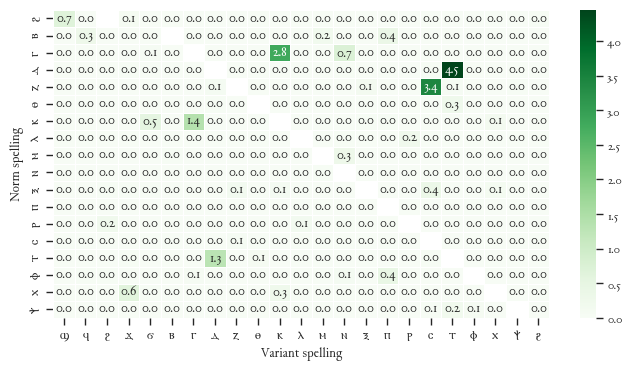

In [81]:
consonant_occurrences = pd.Series({x: df_attestations["greek_lemma"].str.count(x).sum() for x in consonants})

consonant_regularity = consonant_frequency.div(consonant_occurrences, axis="rows").fillna(0)
consonant_regularity = 100 * consonant_regularity.loc[consonant_regularity.any(axis=1), consonant_regularity.any(axis=0)]
write_csv(consonant_regularity, "consonant_regularity")

unique_labels = list(set(consonant_regularity.index).union(set(consonant_regularity.columns)))
for i in unique_labels:
    if i in consonant_regularity.index and i in consonant_regularity.columns:
        consonant_regularity.loc[i, i] = -1

#np.fill_diagonal(consonant_regularity.values, -1)
sns.heatmap(consonant_regularity, cmap="Greens", annot=True, linewidth=0.5, fmt=".1f", mask=(consonant_regularity==-1))
# TODO sort axies
plt.xlabel("Variant spelling")
plt.ylabel("Norm spelling")
write_figure("consonant_regularity")

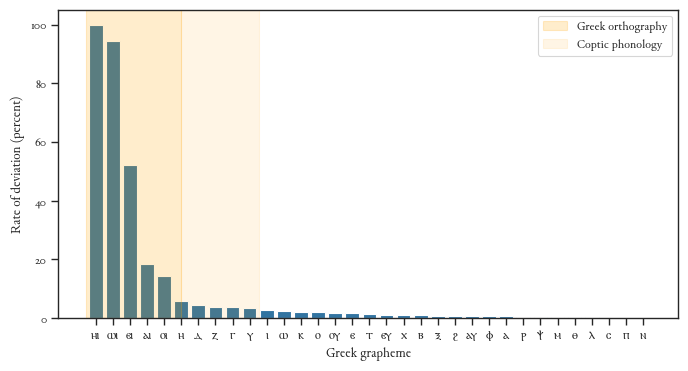

In [82]:
replacements = pd.concat([consonant_regularity.replace(-1, 0).T.sum(), vowel_regularity.replace(-1, 0).T.sum()]).sort_values(ascending=False)
sns.barplot(replacements)
plt.axvspan(xmin=-0.55, xmax=5, color='orange', alpha=0.2, label='Greek orthography')
plt.axvspan(xmin=5, xmax=9.53, color='orange', alpha=0.1, label='Coptic phonology')
#plt.axvspan(xmin=10.55, xmax=34, color='green', alpha=0.1, label='Occasional variation')
#sns.despine(trim=True)
plt.ylabel("Rate of deviation (percent)")
plt.xlabel("Greek grapheme")
plt.legend()
write_figure("deviation_rate_by_grapheme")

/tmp/nix-shell.wTW14Y/ipykernel_2124977/745626487.py:11: RuntimeWarning: invalid value encountered in sqrt
  distance_matrix = 1 - sym_norm_confusion.values ** 0.5


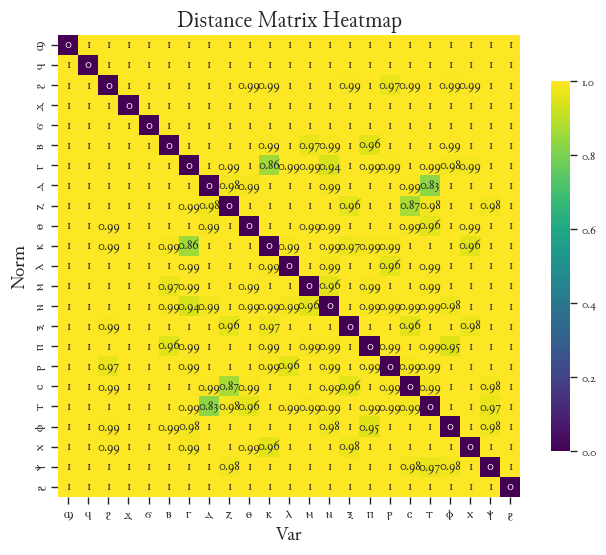

/tmp/nix-shell.wTW14Y/ipykernel_2124977/745626487.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


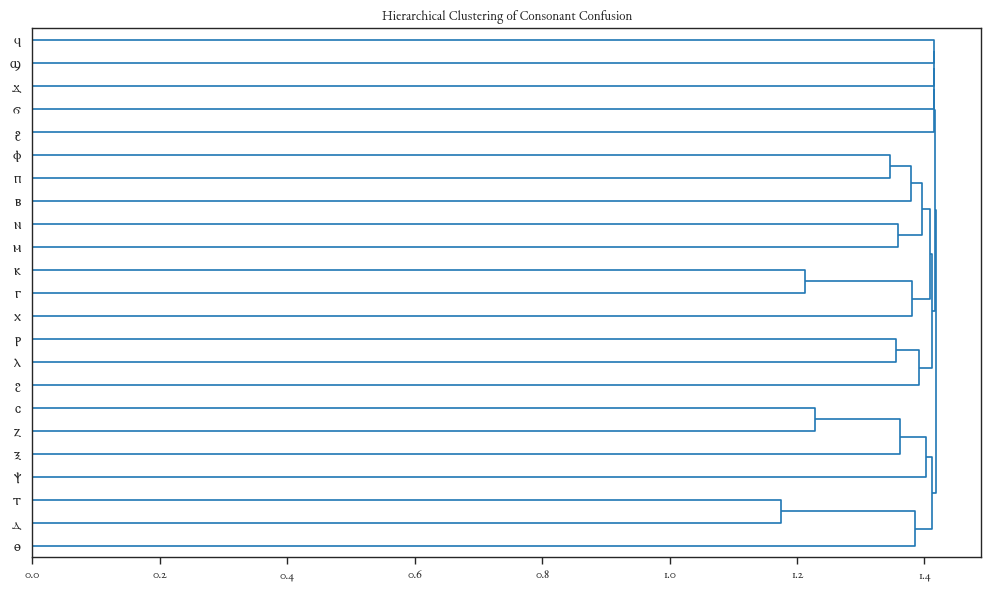

In [83]:
norm_confusion = consonant_frequency.copy().astype(float)

for grapheme in norm_confusion.index:
    if grapheme in consonant_occurrences:
        total = consonant_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)
np.fill_diagonal(distance_matrix, 0)
distance_matrix[np.isnan(distance_matrix)] = 1
distance_df.iloc[:, :] = distance_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)
plt.show()

from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Consonant Confusion")
plt.tight_layout()
plt.show()

In [84]:
all_consonant_regularities = pd.DataFrame(consonant_regularity.stack()).reset_index().rename(columns={"level_0": "norm", "norm": "var", 0: "regularity"})
all_consonant_frequencies  = pd.DataFrame(consonant_frequency.stack()).reset_index().rename(columns={0: "frequency"})
consonant_deviations = pd.merge(all_consonant_regularities, all_consonant_frequencies, on=["norm", "var"])
write_csv(consonant_deviations, "deviations-consonants")

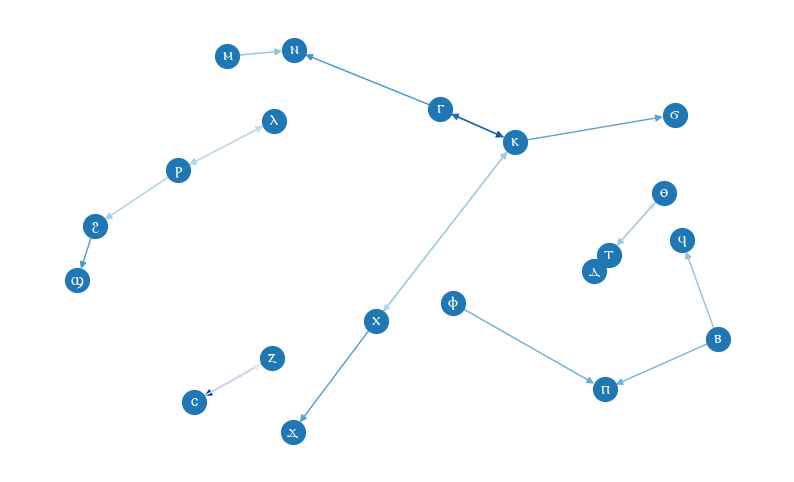

In [85]:
graph = nx.from_pandas_edgelist(
    consonant_deviations[consonant_deviations["frequency"] >= 20],
    source="norm",
    target="var",
    edge_attr=["frequency", "regularity"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, k=2.2, weight="frequency", seed=342)

fig = plt.figure(figsize=(10, 6))
nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(r) for r in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)
fig.savefig(subdirectory / "figure-consonants_graph.svg")
plt.show()

In [86]:
obstruents = ["ⲃ", "ⲇ", "ⲅ", "ⲡ", "ⲧ", "ⲕ", "ⲫ", "ⲑ", "ⲭ", "ⲥ", "ⲍ"]
stops = df_diff[df_diff["norm"].isin(obstruents)].copy()
stops["realization"] = stops["var"].apply(lambda x: "voiceless plosive (ⲡ, ⲧ, ϭ, ⲕ)" if x in {"ⲡ", "ⲧ", "ⲕ"} else "voiced plosive (ⲇ, ⲅ)" if x in {"ⲇ", "ⲅ"} else "plosive (ⲡ, ⲧ, ⲕ) + ϩ" if x in {"ⲡϩ", "ⲧϩ", "ⲕϩ"} else "voiceless fricative (ϥ, ⲥ, ϣ, ϧ/ⳉ, ϩ)" if x in {"ϩ", "ϥ", "ⲥ", "ϣ", "ϧ", "ⳉ"} else "voiced fricative (ⲃ, ⲍ)" if x in {"ⲃ", "ⲍ"} else None)

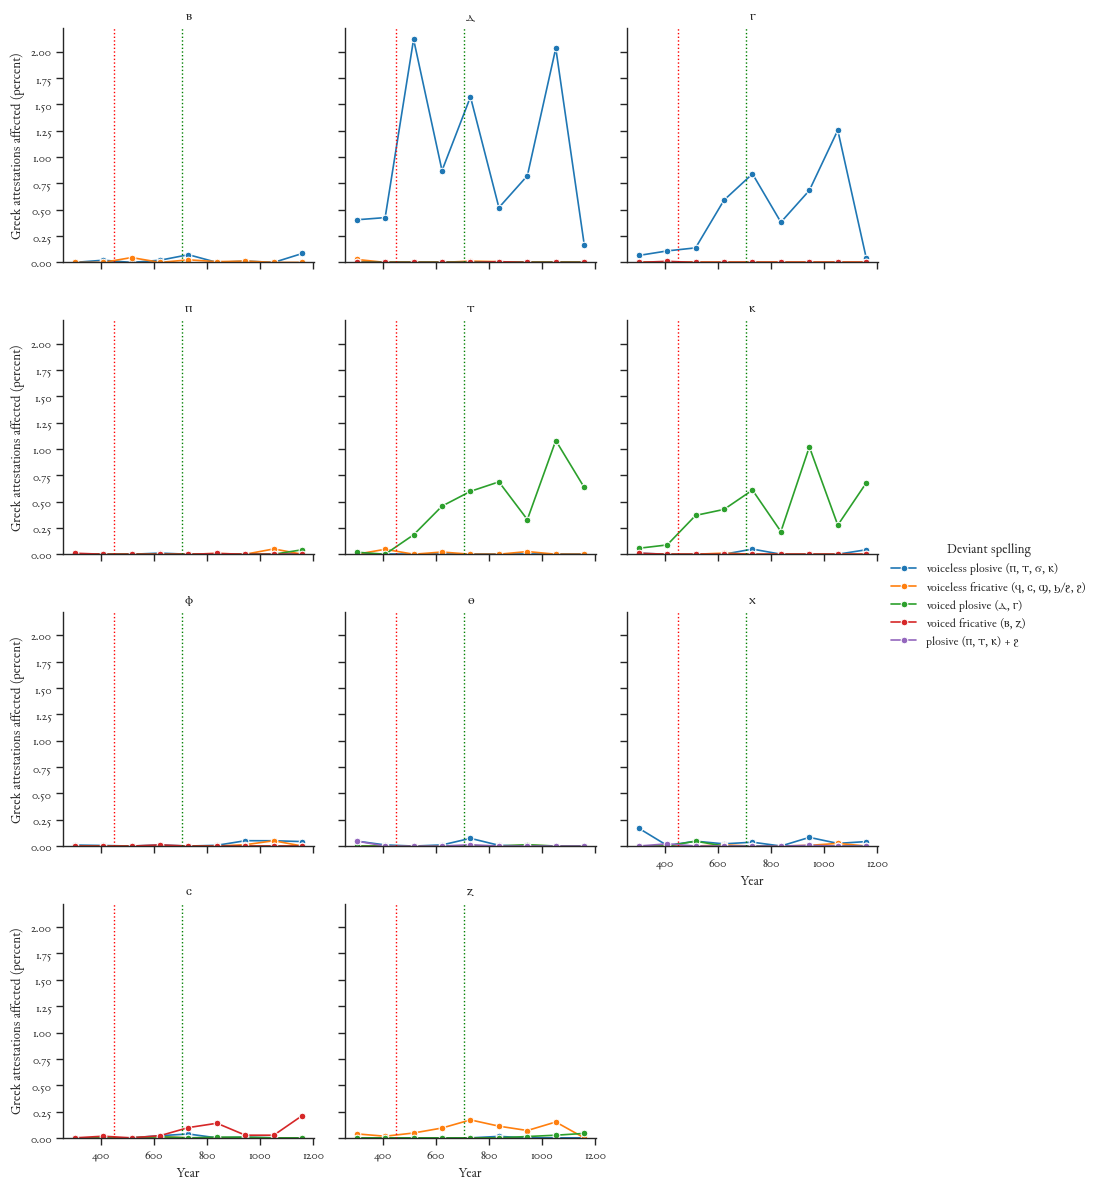

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_data = []

# Iterate over each combination of norm and realization
for norm_value in stops["norm"].unique():
    norm_subset = stops[stops["norm"] == norm_value]

    for realization_value in norm_subset["realization"].dropna().unique():
        subset = norm_subset[norm_subset["realization"] == realization_value]
        dates = subset['date_approximate'].dropna()

        # Histogram
        counts, _ = np.histogram(dates, bins=bins)
        ratio = counts / full_counts_safe
        
        # Collect results
        for x, y in zip(bin_centers, ratio):
            plot_data.append({
                'year': x,
                'ratio': y * 100,
                'norm': norm_value,
                'realization': realization_value
            })

plot_df = pd.DataFrame(plot_data)

g = sns.FacetGrid(plot_df, col="norm", hue="realization", col_wrap=3, sharey=True, col_order=obstruents,)
g.map_dataframe(sns.lineplot, marker='o', x="year", y="ratio")#.add_legend()
g.set(ylim=0)
g.set_axis_labels("Year", "Greek attestations affected (percent)")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    add_external_history(ax)

g.add_legend(title="Deviant spelling")
#plt.tight_layout()
plt.show()
g.savefig(subdirectory / "figure-plosives_by_year.svg")


## What influences plosive deviation?

In [88]:
def categorize(row):
    #if row["shift_class"] == 'voiceless_aspirated':
    #    return "aspiration"
    if row['shift_class'] == "voiced_voiceless":
        return "voicing"
    else:
        return "other"

xtab_aspiration = pd.crosstab(df_diff.apply(categorize, axis=1), df_diff.dialect_group == "B").rename(
    columns={ True: 'B', False: 'non-B' },
)

stat_aspiration = contingency_statistics(xtab_aspiration)

write_csv(xtab_aspiration, "aspiration")
write_json(stat_aspiration, "aspiration")

print(stat_aspiration)
xtab_aspiration #/ expected

{'chi^2': 52.33374173055323, 'p': 4.682592921607028e-13, 'df': 1, 'V': 0.03452055060795371}


dialect_group,non-B,B
row_0,,
other,38272,2428
voicing,3556,112


In [89]:
xtab_aspiration_deluxe = chi2_deluxe(xtab_aspiration)
write_csv(xtab_aspiration_deluxe, "aspiration_contributions")
xtab_aspiration_deluxe

dialect_group,non-B,B
row_0,,
other,"–, χ² = 0.25 n. s.","+, χ² = 4.12 n. s."
voicing,"+, χ² = 2.78 n. s.","–, χ² = 45.72 ***"


## What influences palatalization?

In [90]:
def categorize(row):
    if row["norm"] in {'ⲧ', 'ⲇ'} and row["var"] == "ⲥ":
        return "ⲧ/ⲥ"
    elif row["norm"] in {"ⲕ", "ⲅ"} and row["var"] == "ϭ":
        return "ⲕ/ϭ"
    elif row["norm"] == "ⲭ" and row["var"] == "ϫ":
        return "ⲭ/ϫ"
    elif row["norm"] == 'ⲧ' and row["var"] == "ϫ":
        return "ⲧ/ϫ"
    elif row["norm"] == "ϩ" and row["var"] in {"ϣ", "ϫ"}:
        return "ϩ/ϣ"
    else:
        return "other"

xtab_palatalization = pd.crosstab(df_diff.apply(categorize, axis=1), df_diff.dialect_group).reindex(index=["ⲧ/ⲥ", "ⲧ/ϫ", "ⲭ/ϫ", "ⲕ/ϭ", "ϩ/ϣ", "other"])

stat_palatalization = contingency_statistics(xtab_palatalization)

write_csv(xtab_palatalization, "palatalization")
write_json(stat_palatalization, "palatalization")

print(stat_palatalization)
xtab_palatalization

{'chi^2': 1893.0044261983192, 'p': 0.0, 'df': 25, 'V': 0.09237530523230364}


dialect_group,B,F,M,S,L,A
row_0,,,,,,
ⲧ/ⲥ,2,0,11,9,1,0
ⲧ/ϫ,14,0,0,0,0,0
ⲭ/ϫ,0,3,51,22,31,11
ⲕ/ϭ,0,4,52,138,8,2
ϩ/ϣ,0,0,0,61,17,0
other,2524,2166,1126,36109,1522,484


In [91]:
xtab_palatalization_deluxe = chi2_deluxe(xtab_palatalization)
write_csv(xtab_palatalization_deluxe, "palatalization_contributions")
xtab_palatalization_deluxe

dialect_group,B,F,M,S,L,A
row_0,,,,,,
ⲧ/ⲥ,"+, χ² = 0.35 n. s.","–, χ² = 1.13 n. s.","+, χ² = 166.88 ***","–, χ² = 5.14 n. s.","+, χ² = 0.04 n. s.","–, χ² = 0.26 n. s."
ⲧ/ϫ,"+, χ² = 217.35 ***","–, χ² = 0.69 n. s.","–, χ² = 0.39 n. s.","–, χ² = 11.47 *","–, χ² = 0.50 n. s.","–, χ² = 0.16 n. s."
ⲭ/ϫ,"–, χ² = 6.76 n. s.","–, χ² = 1.34 n. s.","+, χ² = 689.99 ***","–, χ² = 57.65 ***","+, χ² = 171.04 ***","+, χ² = 70.86 ***"
ⲕ/ϭ,"–, χ² = 11.68 *","–, χ² = 3.59 n. s.","+, χ² = 375.97 ***","–, χ² = 5.06 n. s.","+, χ² = 0.08 n. s.","–, χ² = 0.04 n. s."
ϩ/ϣ,"–, χ² = 4.47 n. s.","–, χ² = 3.82 n. s.","–, χ² = 2.18 n. s.","–, χ² = 0.13 n. s.","+, χ² = 72.89 ***","–, χ² = 0.87 n. s."
other,"+, χ² = 0.03 n. s.","+, χ² = 0.10 n. s.","–, χ² = 8.44 n. s.","+, χ² = 0.45 n. s.","–, χ² = 1.10 n. s.","–, χ² = 0.13 n. s."


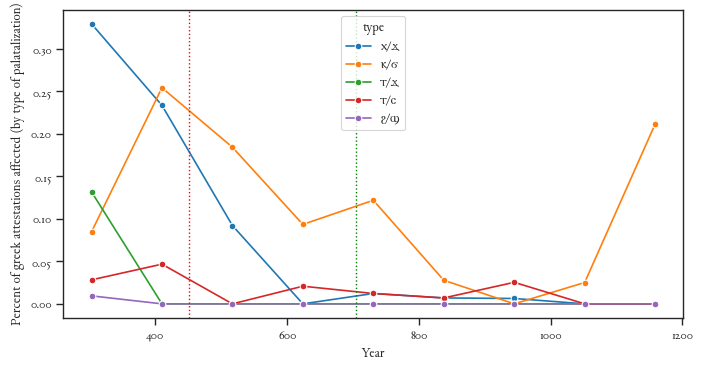

In [92]:
plot_data = []

df_diff["palatalization_type"] = df_diff.apply(categorize, axis=1)

# Iterate over each combination of norm and realization
for pala_value in df_diff["palatalization_type"].unique():
    if pala_value == "other": continue
    pala_subset = df_diff[df_diff["palatalization_type"] == pala_value]

    dates = pala_subset['date_approximate'].dropna()

    # Histogram
    counts, _ = np.histogram(dates, bins=bins)
    ratio = counts / full_counts_safe
    
    # Collect results
    for x, y in zip(bin_centers, ratio):
        plot_data.append({
            'year': x,
            'ratio': y * 100,
            'type': pala_value,
        })

plot_df = pd.DataFrame(plot_data)
ax = sns.lineplot(plot_df, x="year", y="ratio", hue="type", marker="o")
add_external_history(ax)
plt.ylabel("Percent of greek attestations affected (by type of palatalization)")
plt.xlabel("Year")
write_figure("palatalizations")
plt.show()


# What influences nasal prosthesis?

In [93]:
df_diff[(df_diff["norm"] == "∅") & (df_diff["var"].isin({"ⲛ", "ⲙ"})) & (df_diff["context_left"] == "#")].sample(5)

,id,norm,var,context_left,context_right,greek_lemma,greek_lemma_original,orthography,orthography_clean,dialect,dialect_group,manuscript_text,date_approximate,earliest,latest,century,shift_class,shift_origin,palatalization_type
22554,85503,∅,ⲙ,#,ⲡⲁⲣⲁ,ⲡⲁⲣⲁ,παρά,ⲙⲡⲁⲣⲁ,ⲙⲡⲁⲣⲁ,S,S,Pierpont Morgan M.595 - Homily on the Passion ...,849.5,825.0,874.0,9.0,nasal,egyptian,other
2506,120728,∅,ⲛ,#,ⲇⲉ,ⲇⲉ,δέ,ⲛ̄ⲇ[ⲉ],ⲛⲇⲉ,L6,L,"P. Heid. Inv. Kopt. 300 + 301 - Acts of Paul, The",399.5,300.0,499.0,4.0,nasal,egyptian,other
2467,117157,∅,ⲛ,#,ⲇⲉ,ⲇⲉ,δέ,ⲛ̄[ⲇ]ⲉ,ⲛⲇⲉ,L6,L,"P. Heid. Inv. Kopt. 300 + 301 - Acts of Paul, The",399.5,300.0,499.0,4.0,nasal,egyptian,other
6826,122583,∅,ⲛ,#,ⲇⲉ,ⲇⲉ,δέ,ⲛ̣̄ⲇ̣[ⲉ],ⲛⲇⲉ,L6,L,Nag Hammadi Codex XI - Interpretation of Knowl...,NaN,NaN,NaN,NaN,nasal,egyptian,other
6676,103500,∅,ⲛ,#,ⲅⲁⲣ,ⲅⲁⲣ,γάρ,ⲛ̄ⲅⲁⲣ,ⲛⲅⲁⲣ,L6,L,Nag Hammadi Codex I - Treatise on the Resurrec...,NaN,NaN,NaN,NaN,nasal,egyptian,other


## What influences lambdacism?

In [94]:
xtab_lambdacism = pd.crosstab(
    df_diff['shift_class'] == "lambdacism",
    df_diff['dialect_group'].isin({"F"})
).rename(
    columns={False: "S/B/M/L/A", True: "F"},
    index={True: "lambdacism", False: "other"}
)


stat_lambdacism = contingency_statistics(xtab_lambdacism)

write_csv(xtab_lambdacism, "lambdacism")
write_json(stat_lambdacism, "lambdacism")

print(stat_lambdacism)
xtab_lambdacism

{'chi^2': 2.1544136810185988, 'p': 0.14216070104761824, 'df': 1, 'V': 0.007794396865947737}


dialect_group,S/B/M/L/A,F
shift_class,,
other,42021,2169
lambdacism,174,4


In [95]:
chi2_deluxe(xtab_lambdacism)

dialect_group,S/B/M/L/A,F
shift_class,,
other,"–, χ² = 0.00 n. s.","+, χ² = 0.01 n. s."
lambdacism,"+, χ² = 0.13 n. s.","–, χ² = 2.55 n. s."


# What influences aspiration?

In [96]:
vowel = ("ⲁ", "ⲉ", "ⲓ", "ⲟ", "ⲩ", "ⲏ", "ⲱ")
vowel_or_spiritus = tuple([*vowel, *map(lambda x: "ϩ" + x, vowel)])

vocalic_initial = df_attestations[df_attestations["greek_lemma"].str.startswith(vowel_or_spiritus) & df_attestations["orthography_clean"].str.startswith(vowel_or_spiritus)]

vocalic_initial = vocalic_initial.assign(
    greek_h=vocalic_initial["greek_lemma"].str.startswith("ϩ"),
    coptic_h=vocalic_initial["orthography_clean"].str.startswith("ϩ")
)
vocalic_initial["century"] = (vocalic_initial["date_approximate"] // 100)

pattern = re.compile(r"ⲁⲩ|ⲁⲓ|ⲉⲓ|ⲟⲩ|ⲟⲓ|ⲉⲩ|[ⲁⲉⲓⲟⲩⲏⲱ]")

def find_first_vowel(text):
    match = pattern.search(text)
    return match.group(0) if match else None

vocalic_initial["initial_vowel"] = vocalic_initial["greek_lemma"].apply(find_first_vowel)

In [97]:
vocalic_initial.greek_h.value_counts() / 9150

greek_h
False    5.882295
True     1.000656
Name: count, dtype: float64

In [98]:
xtab_spiritus = pd.crosstab(vocalic_initial["greek_h"], vocalic_initial["coptic_h"], normalize=True)
write_csv(xtab_spiritus, "spiritus")
xtab_spiritus

coptic_h,False,True
greek_h,,
False,0.818749,0.035869
True,0.013782,0.131599


In [99]:
agreement = (vocalic_initial['greek_h'] == vocalic_initial['coptic_h']).mean()
agreement

0.9503485288747042

In [100]:
def f_score(df):
    TP = df[(df['greek_h'] & df['coptic_h'])].size
    TN = df[(~df['greek_h'] & ~df['coptic_h'])].size
    FP = df[(~df['greek_h'] & df['coptic_h'])].size
    FN = df[(df['greek_h'] & ~df['coptic_h'])].size
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {"precision": precision, "recall": recall, "f1_score": f1_score}

write_json(f_score(vocalic_initial), "h_score")
f_score(vocalic_initial)

{'precision': 0.7858158718118896,
 'recall': 0.9051987767584098,
 'f1_score': 0.8412932040805969}

In [101]:
h_score_dialects = vocalic_initial.groupby('dialect_group').apply(
    lambda g: f_score(g)
).apply(pd.Series)
write_csv(h_score_dialects, "h_score_dialects")
h_score_dialects

/tmp/nix-shell.wTW14Y/ipykernel_2124977/2635419908.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  h_score_dialects = vocalic_initial.groupby('dialect_group').apply(
/tmp/nix-shell.wTW14Y/ipykernel_2124977/2635419908.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  h_score_dialects = vocalic_initial.groupby('dialect_group').apply(


,precision,recall,f1_score
dialect_group,,,
B,0.810954,0.622795,0.704528
F,0.654255,0.931818,0.768750
M,0.542907,0.956790,0.692737
S,0.813020,0.929336,0.867295
L,0.761693,0.952646,0.846535
A,0.474138,0.833333,0.604396


     greek_lemma orthography
7460        ϩⲓⲛⲁ        ϩⲓⲛⲁ
      greek_lemma orthography
60127    ⲓⲟⲩⲇⲁⲓⲟⲥ    ⲓ̈ⲟⲩⲇⲁⲓ̈
      greek_lemma orthography
64740    ⲉⲡⲓⲑⲩⲙⲓⲁ    ⲉⲡⲓⲑⲩⲙⲓⲁ
      greek_lemma orthography
79767      ⲁⲅⲁⲑⲟⲥ    ⲁⲅⲁⲑⲟ[ⲛ]
      greek_lemma orthography
89415        ⲁⲙⲏⲛ       ϩⲁⲙⲏⲛ
       greek_lemma orthography
101166      ⲁⲅⲁⲑⲟⲥ      ⲁⲅⲁⲑⲟⲛ
       greek_lemma orthography
128241        ⲁⲗⲗⲁ        ⲁⲗⲗⲁ
       greek_lemma orthography
134307        ⲁⲣⲭⲱ    [ⲁⲣ]ⲭⲉⲓ̈
       greek_lemma orthography
146405     ⲁⲅⲅⲉⲗⲟⲥ     ⲁⲅⲅⲉⲗⲟⲥ


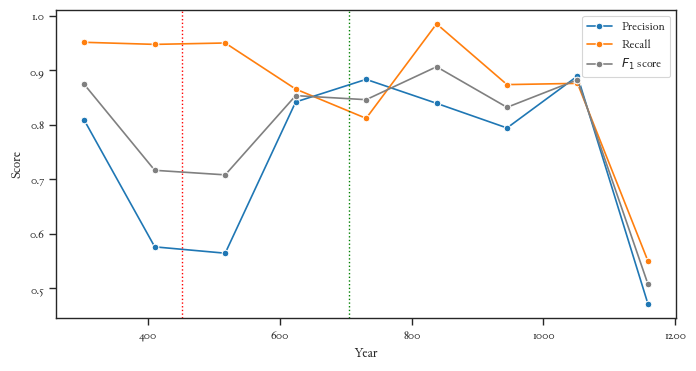

In [102]:
dates = df_attestations['date_approximate'].dropna()
binned_dates = pd.cut(dates, bins=bins)

# Iterate through each bin to calculate F1 score
for interval in binned_dates.cat.categories:
    # Filter the dataset for the current time slice
    time_slice = vocalic_initial[(vocalic_initial['date_approximate'] >= interval.left) & 
                                 (vocalic_initial['date_approximate'] < interval.right)]

    print(time_slice[["greek_lemma", "orthography"]].sample())
    if not time_slice.empty:
        f_score_result = f_score(time_slice)
    else:
        f_score_result = {"f1_score": 0}  # Handle empty slices

    plot_data.append({
        'year': interval.mid,
        'f1_score': f_score_result['f1_score'],
        'precision': f_score_result['precision'],
        'recall': f_score_result['recall'],
    })

# Create DataFrame and plot
plot_df = pd.DataFrame(plot_data).replace(0, np.nan)
sns.lineplot(data=plot_df, x="year", y="precision", marker='o', label='Precision')
sns.lineplot(data=plot_df, x="year", y="recall", marker='o', label='Recall')
sns.lineplot(data=plot_df, x="year", y="f1_score", marker='o', label='$F_1$ score', color='grey')

plt.ylabel("Score")
plt.xlabel("Year")
plt.legend()
add_external_history(plt.gca())
write_figure("precision_recall_f1_over_time")
plt.show()


In [103]:
def categorize(orthography_clean):
    if re.match("^ⲣ[^ϩ]", orthography_clean):
        return "ⲣ-"
    elif re.match("^ⲣϩ", orthography_clean):
        return "ⲣϩ-"
    elif re.match("^ϩⲣ", orthography_clean):
        return "ϩⲣ-"
    elif re.match(".*ⲣⲣ.*", orthography_clean):
        return "-ⲣⲣ-"
    elif re.match(".*ⲣϩ.*", orthography_clean):
        return "-ⲣϩ-"
    elif re.match(".*ϩⲣ.*", orthography_clean):
        return "-ϩⲣ-"
    else:
        return None

xtab_rh = pd.crosstab(
    df_attestations.orthography_clean.apply(categorize).rename("rho"),
    df_attestations.dialect_group
)
write_csv(xtab_rh, "rho")
xtab_rh

dialect_group,B,F,M,S,L,A
rho,,,,,,
-ϩⲣ-,0,0,4,84,2,1
-ⲣϩ-,0,5,6,89,10,5
-ⲣⲣ-,14,4,10,215,12,5
ϩⲣ-,0,3,3,244,5,2
ⲣ-,25,0,0,60,5,0


In [104]:
vocalic_initial[vocalic_initial['greek_h'] != vocalic_initial['coptic_h']]["greek_lemma"].unique()

array(['ⲉⲗⲡⲓⲍⲱ', 'ⲉⲑⲛⲟⲥ', 'ⲉⲗⲡⲓⲥ', 'ⲉⲓ', 'ϩⲁⲣⲙⲁ', 'ϩⲟⲣⲙⲓⲥⲕⲟⲥ', 'ϩⲱⲥ',
       'ⲁⲙⲏⲛ', 'ϩⲁⲅⲓⲟⲥ', 'ⲉⲓⲕⲱⲛ', 'ⲓⲥⲟⲥ', 'ϩⲟⲣⲁⲥⲓⲥ', 'ϩⲉⲱⲥ', 'ϩⲟⲥⲟⲥ',
       'ϩⲟⲧⲓ', 'ϩⲓⲛⲁ', 'ϩⲁⲗⲩⲥⲓⲥ', 'ⲓⲥⲁⲅⲅⲉⲗⲟⲥ', 'ⲉⲓⲣⲏⲛⲏ', 'ϩⲟⲙⲓⲗⲓⲁ',
       'ⲟⲃⲟⲗⲟⲥ', 'ⲱⲓⲇⲏ', 'ϩⲟⲙⲟⲗⲟⲅⲉⲱ', 'ϩⲟⲗⲟⲥ', 'ϩⲟⲣⲙⲏ', 'ⲁⲗⲁⲕⲁⲧⲁ',
       'ϩⲓⲥⲧⲏⲙⲓ', 'ⲉⲧⲁⲍⲱ', 'ϩⲩⲡⲁⲣⲭⲱ', 'ⲟⲣⲅⲏ', 'ϩⲩⲇⲱⲣ', 'ϩⲟⲙⲟⲩ', 'ϩⲉⲕⲧⲟⲥ',
       'ⲁⲣⲁ', 'ϩⲩⲡⲏⲣⲉⲧⲉⲱ', 'ϩⲟⲧⲁⲛ', 'ϩⲩⲡⲟⲙⲉⲛⲱ', 'ϩⲩⲃⲣⲓⲥ', 'ⲉⲑⲛⲓⲕⲟⲥ',
       'ⲏⲇⲏ', 'ϩⲩⲓⲟⲥ', 'ⲉⲛⲛⲉⲁⲥ', 'ⲉⲓⲗⲓⲕⲣⲓⲛⲏⲥ', 'ⲟⲅⲇⲟⲁⲥ', 'ϩⲉⲝⲁⲥ',
       'ϩⲏⲗⲓⲁⲕⲟⲥ', 'ϩⲩⲡⲉⲣⲁⲥⲁⲗⲉⲩⲧⲟⲥ', 'ⲓⲇⲓⲟⲥ', 'ⲁⲅⲛⲉⲓⲁ', 'ϩⲩⲡⲟⲭⲟⲛⲇⲣⲓⲟⲥ',
       'ϩⲏⲗⲓⲟⲥ', 'ⲟⲗⲓⲅⲟⲥ', 'ϩⲏⲛⲓⲟⲭⲟⲥ', 'ϩⲉⲗⲗⲉⲃⲟⲣⲟⲥ', 'ϩⲉⲣⲙⲏⲛⲉⲩⲱ', 'ⲓⲇⲉⲁ',
       'ⲓⲥⲟⲇⲩⲛⲁⲙⲓⲁ', 'ⲓⲥⲟⲭⲣⲟⲛⲟⲥ', 'ⲉⲓⲕⲟⲛⲓⲕⲟⲥ', 'ϩⲟⲓⲟⲥ', 'ⲟⲓⲕⲟⲛⲟⲙⲓⲁ',
       'ϩⲁⲅⲗⲁⲟⲥ', 'ⲟⲡⲱⲣⲁ', 'ⲓⲥⲟⲇⲩⲛⲁⲙⲟⲥ', 'ϩⲱⲥⲁⲛⲛⲁ', 'ⲓⲇⲓⲱⲧⲏⲥ', 'ⲉⲑⲟⲥ',
       'ⲟⲕⲛⲉⲱ', 'ⲓⲧⲁⲗⲓⲕⲟⲥ', 'ⲁⲣⲙⲁ', 'ϩⲓⲉⲣⲁⲧⲓⲕⲟⲥ', 'ⲏⲧⲣⲟⲛ', 'ϩⲁⲣⲡⲁⲍⲱ',
       'ϩⲟⲡⲗⲟⲛ', 'ⲁⲙⲙⲁⲛⲓⲧⲏⲥ', 'ϩⲏⲥⲩⲭⲁⲍⲱ', 'ϩⲟⲙⲟⲓⲟⲥ', 'ϩⲉⲧⲟⲓⲙⲟⲥ',
       'ϩⲁⲅⲓⲱⲥⲩⲛⲏ', 'ϩⲁⲡⲗⲱⲥ', 'ϩⲉⲃⲇⲟⲙⲁⲥ', 'ⲁⲛⲁⲗⲱⲙⲁ', 'ⲟⲕⲛⲟⲥ', 'ⲉⲑⲱ',
       'ϩⲉⲯⲏⲙⲁ', 'ϩⲁⲗⲱⲛⲓⲁ'

<Axes: xlabel='date_approximate', ylabel='Count'>

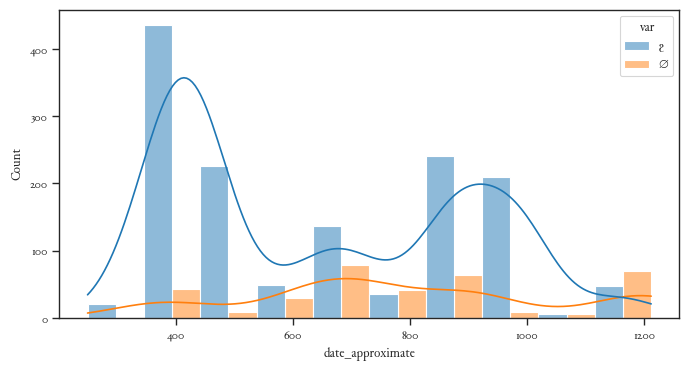

In [105]:
un_aspiration = df_diff[((df_diff["norm"] == "ϩ") & (df_diff["var"] == "∅")) | ((df_diff["norm"] == "∅") & (df_diff["var"] == "ϩ"))].copy()
sns.histplot(data=un_aspiration, x='date_approximate', hue='var', multiple="dodge", bins=number_of_bins, kde=True)

# Syncope

In [126]:
xtab_dialect_syncope = pd.crosstab(
    df_diff['shift_class'] == "syncope",
    df_diff['dialect_group']#.isin({"F"})
).rename(
    #columns={False: "S/B/M/L/A", True: "F"},
    index={True: "vowel deletion", False: "other"}
)

stat_dialect_sycope = contingency_statistics(xtab_dialect_syncope)

write_csv(xtab_dialect_syncope, "dialect_syncope")
write_json(stat_dialect_sycope, "dialect_syncope")

print(stat_dialect_sycope)
xtab_dialect_syncope

{'chi^2': 110.18164576940362, 'p': 3.7507023254546894e-22, 'df': 5, 'V': 0.0498333061944556}


dialect_group,B,F,M,S,L,A
shift_class,,,,,,
other,2506,2125,1234,34984,1557,487
vowel deletion,34,48,6,1355,22,10


In [127]:
df_diff[(df_diff['shift_class'] == "vowel deletion") & (df_diff['dialect_group'] == "M")]

,id,norm,var,context_left,context_right,greek_lemma,greek_lemma_original,orthography,orthography_clean,dialect,dialect_group,manuscript_text,date_approximate,earliest,latest,century,shift_class,shift_origin,palatalization_type


In [128]:
xtab_dialect_syncope_deluxe = chi2_deluxe(xtab_dialect_syncope)
write_csv(xtab_dialect_syncope_deluxe.T, "dialect_syncope_contributions")
xtab_dialect_syncope_deluxe

dialect_group,B,F,M,S,L,A
shift_class,,,,,,
other,"+, χ² = 1.04 n. s.","+, χ² = 0.28 n. s.","+, χ² = 1.03 n. s.","–, χ² = 0.61 n. s.","+, χ² = 0.61 n. s.","+, χ² = 0.09 n. s."
vowel deletion,"–, χ² = 30.13 ***","–, χ² = 8.13 n. s.","–, χ² = 30.10 ***","+, χ² = 17.87 ***","–, χ² = 17.71 ***","–, χ² = 2.57 n. s."


# Epenthesis

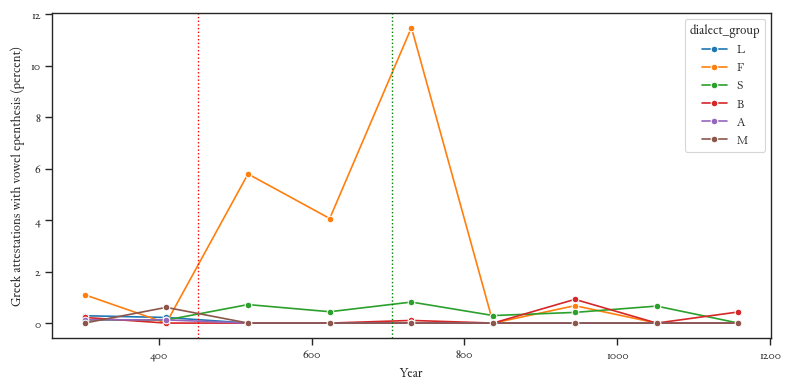

In [109]:
epentheses = df_diff[(df_diff["norm"] == "∅") & df_diff["var"].isin(vowels | diphthongs)].copy()
#epentheses["inserted vowel"] = epentheses["var"].apply(lambda x: "close front vowel" if x in {"ⲓ", "ⲩ", "ⲉⲓ"} else "close-mid front vowel" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "back vowel" if x in {"ⲱ", "ⲟ", "ⲟⲩ"} else "ⲁ /a/" if x in {"ⲁ"} else None)

plot_data = []

# Iterate over each combination of norm and realization

for dialect_group in epentheses["dialect_group"].dropna().unique():
    subset = epentheses[epentheses["dialect_group"] == dialect_group]
    dates = subset['date_approximate'].dropna()

    # Histogram
    counts, _ = np.histogram(dates, bins=bins)
    ratio = counts / full_counts_per_dialect[dialect_group]
    
    # Collect results
    for x, y in zip(bin_centers, ratio):
        plot_data.append({
            'year': x,
            'ratio': y * 100,
            'dialect_group': dialect_group
        })

plot_df = pd.DataFrame(plot_data)

ax = sns.lineplot(plot_df, x="year", y="ratio", hue="dialect_group", marker='o')

plt.xlabel("Year")
plt.ylabel("Greek attestations with vowel epenthesis (percent)")

add_external_history(ax)

plt.tight_layout()
write_figure("epenthesis_by_year")
plt.show()


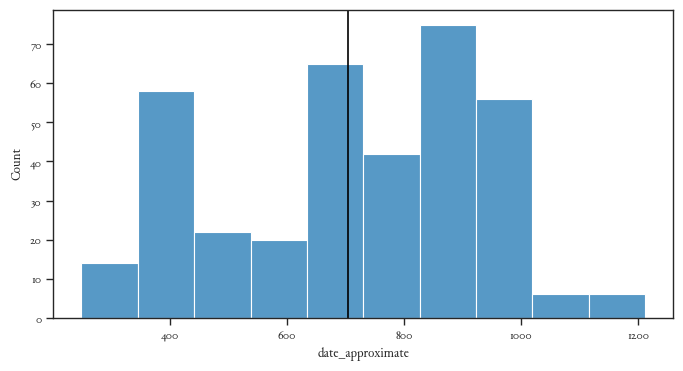

In [110]:
sns.histplot(epentheses, x="date_approximate", kde=False)#(interesting_insertions["var"], interesting_insertions["century"]).style.background_gradient(axis=None, cmap=cm)
plt.axvline(x=705, color="black", label="Arabic becomes official language")
#plt.legend()

In [111]:
xtab_epenthesis = pd.crosstab(df_diff["shift_class"] == "epenthesis", df_diff["date_approximate"] > 705).rename(
    columns={True: "Arab era", False: "pre-Arab era"},
    index={True: "vowel epenthesis", False: "other"}
)
stat_epenthesis = contingency_statistics(xtab_epenthesis)

write_csv(xtab_epenthesis, "epenthesis")
write_json(stat_epenthesis, "epenthesis")

print(stat_epenthesis)
xtab_epenthesis

{'chi^2': 12.687792418507794, 'p': 0.0003680505369311368, 'df': 1, 'V': 0.017097957091321177}


date_approximate,pre-Arab era,Arab era
shift_class,,
other,30559,13028
vowel epenthesis,594,187


In [112]:
df_diff[df_diff.shift_class == "epenthesis"].sample(10)

,id,norm,var,context_left,context_right,greek_lemma,greek_lemma_original,orthography,orthography_clean,dialect,dialect_group,manuscript_text,date_approximate,earliest,latest,century,shift_class,shift_origin,palatalization_type
21147,77041,∅,ⲁ,ⲭⲁⲗ,ⲕⲁⲛⲑⲟⲛ,ⲭⲁⲗⲕⲁⲛⲑⲟⲛ,χάλκανθον,ⲕⲁⲗⲁⲑⲁⲛⲑ,ⲕⲁⲗⲁⲑⲁⲛⲑ,S,S,Cairo - IFAO P.No. unknown - P.Méd.Copt. IFAO ...,899.5,800.0,999.0,9.0,epenthesis,egyptian,other
43709,120146,∅,ⲏ,ⲁⲣⲭ,ⲁⲅⲅⲉⲗⲟⲥ,ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ,ἀρχάγγελος,ⲁⲣⲭⲏ\ⲁⲅⲅⲉⲗⲟⲥ,ⲁⲣⲭⲏⲁⲅⲅⲉⲗⲟⲥ,B,B,Rome - Vatican - Biblioteca del Vaticano Vat. ...,NaN,NaN,NaN,NaN,epenthesis,egyptian,other
39734,71778,∅,ⲁ,ⲭⲉⲓⲣ,#,ⲭⲉⲓⲣ,χείρ,ⲭⲉⲓⲣⲁ,ⲭⲉⲓⲣⲁ,S,S,Vienna - Nationalbibliothek Κ 10992 - P.KRU 22...,NaN,NaN,NaN,NaN,epenthesis,egyptian,other
33686,108789,∅,ⲉ,ⲉⲓ,ⲙⲏⲧⲓ,ⲉⲓⲙⲏⲧⲓ,εἰ μή τι,ⲉⲓⲉ̄ⲙⲏⲧⲉⲓ,ⲉⲓⲉⲙⲏⲧⲉⲓ,S,S,INTF Acta* (sahidic) - Acts of the Apostles,NaN,NaN,NaN,NaN,epenthesis,egyptian,other
28216,121624,∅,ⲱ,ⲕⲟⲙⲓⲧⲁⲧ,ⲛ,ⲕⲟⲙⲓⲧⲁⲧⲛ,κομιτάτoν,ⲕⲟⲙⲉⲧⲁⲧⲱⲛ,ⲕⲟⲙⲉⲧⲁⲧⲱⲛ,S,S,White Monastery codex GC - First Panegyric on ...,999.5,900.0,1099.0,10.0,epenthesis,egyptian,other
5383,50905,∅,ⲁ,ⲥⲁⲣ,ⲝ,ⲥⲁⲣⲝ,σάρξ,ⲥⲁⲣⲁⲝ,ⲥⲁⲣⲁⲝ,S,S,Nag Hammadi Codex IX - Testimony of Truth,NaN,NaN,NaN,NaN,epenthesis,egyptian,other
10111,49200,∅,ⲏ,ⲧⲉⲭ,ⲛⲓⲧⲏⲥ,ⲧⲉⲭⲛⲓⲧⲏⲥ,τεχνίτης,ⲧⲉⲭⲏⲛⲓⲧⲏⲥ,ⲧⲉⲭⲏⲛⲓⲧⲏⲥ,S,S,London - British Museum EA 32886 - O.Crum 106,NaN,500.0,799.0,NaN,epenthesis,egyptian,other
25362,46893,∅,ⲉ,ⲥⲧⲁⲧⲏⲣ,#,ⲥⲧⲁⲧⲏⲣ,στατήρ,ⲥⲁⲧⲏⲏⲣⲉ,ⲥⲁⲧⲏⲏⲣⲉ,S,S,New York - The Morgan Library and Museum M612 ...,889.5,880.0,899.0,9.0,epenthesis,egyptian,other
18867,64211,∅,ⲓ,ϩⲩⲡⲟⲧⲁⲥ,ⲥⲱ,ϩⲩⲡⲟⲧⲁⲥⲥⲱ,ὑποτάσσω,ϩⲩⲡⲟ|ⲧⲁⲥⲓ̈ⲥ,ϩⲩⲡⲟⲧⲁⲥⲓⲥ,S,S,New York - The Morgan Library and Museum M609 ...,862.0,800.0,924.0,9.0,epenthesis,egyptian,other
22271,150586,∅,ⲓ,ⲧⲁⲣⲓⲭ,ⲟⲛ,ⲧⲁⲣⲓⲭⲟⲛ,τάριχον,ⲧⲁⲣⲓⲭⲓⲟⲛ,ⲧⲁⲣⲓⲭⲓⲟⲛ,S,S,New York - The Morgan Library and Museum M.586...,837.0,825.0,849.0,9.0,epenthesis,egyptian,other


In [113]:
xtab_dialect_epenthesis = pd.crosstab((df_diff["shift_class"] == "epenthesis"), df_diff["dialect_group"]).rename(
    columns={True: "B", False: "non-B"},
    index={True: "vowel epenthesis", False: "other"}
)

stat_dialect_epenthesis = contingency_statistics(xtab_dialect_epenthesis)

write_csv(xtab_dialect_epenthesis, "dialect_epenthesis")
write_json(stat_dialect_epenthesis, "dialect_epenthesis")

print(stat_dialect_epenthesis)
xtab_dialect_epenthesis

{'chi^2': 150.16136173045012, 'p': 1.2336103474322084e-30, 'df': 5, 'V': 0.05817604228715276}


dialect_group,B,F,M,S,L,A
shift_class,,,,,,
other,2438,2122,1184,35798,1554,491
vowel epenthesis,102,51,56,541,25,6


In [114]:
xtab_dialect_epenthesis_deluxe = chi2_deluxe(xtab_dialect_epenthesis)
write_csv(xtab_dialect_epenthesis_deluxe.T, "dialect_epenthesis_contributions")
xtab_dialect_epenthesis_deluxe

dialect_group,B,F,M,S,L,A
shift_class,,,,,,
other,"–, χ² = 1.32 n. s.","–, χ² = 0.08 n. s.","–, χ² = 0.96 n. s.","+, χ² = 0.27 n. s.","+, χ² = 0.01 n. s.","+, χ² = 0.02 n. s."
vowel epenthesis,"+, χ² = 73.41 ***","+, χ² = 4.25 n. s.","+, χ² = 53.50 ***","–, χ² = 15.22 **","–, χ² = 0.28 n. s.","–, χ² = 0.86 n. s."


# Older words — older pronunciations

In [115]:
# Group by both 'greek_lemma' and 'dialect_group' to get the minimum date
date_per_lemma = df_diff.groupby(["greek_lemma", "dialect_group"])["date_approximate"].min()

# Count deviations per lemma and dialect group
deviations_per_lemma = df_diff.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()

# Count attestations per lemma and dialect group
attestations_per_lemma = df_attestations.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()

# Create a DataFrame with the results
per_lemma = pd.DataFrame({
    "earliest_attestation": date_per_lemma,
    "deviations": deviations_per_lemma,
    "attestations": attestations_per_lemma
}).dropna()

# Calculate the deviation rate
per_lemma["deviation_rate"] = per_lemma["deviations"].div(per_lemma["attestations"])

# Reset index to make 'greek_lemma' and 'dialect_group' columns
per_lemma = per_lemma.reset_index()
per_lemma

/tmp/nix-shell.wTW14Y/ipykernel_2124977/682983015.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  date_per_lemma = df_diff.groupby(["greek_lemma", "dialect_group"])["date_approximate"].min()
/tmp/nix-shell.wTW14Y/ipykernel_2124977/682983015.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deviations_per_lemma = df_diff.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()
/tmp/nix-shell.wTW14Y/ipykernel_2124977/682983015.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

,greek_lemma,dialect_group,earliest_attestation,deviations,attestations,deviation_rate
0,ϩⲁⲅⲁⲣⲓⲛⲛⲁⲓⲟⲥ,B,1212.0,2.0,1,2.000000
1,ϩⲁⲅⲓⲁⲍⲱ,S,949.5,3.0,18,0.166667
2,ϩⲁⲅⲓⲟⲥ,B,699.5,181.0,178,1.016854
3,ϩⲁⲅⲓⲟⲥ,S,559.5,81.0,943,0.085896
4,ϩⲁⲅⲓⲟⲧⲏⲥ,S,699.5,2.0,1,2.000000
...,...,...,...,...,...,...
3204,ⲱⲫⲉⲗⲉⲓⲁ,F,799.5,4.0,2,2.000000
3205,ⲱⲫⲉⲗⲉⲓⲁ,S,999.5,26.0,16,1.625000
3206,ⲱⲫⲉⲗⲉⲱ,S,699.5,31.0,65,0.476923
3207,ⲱⲫⲉⲗⲉⲱ,A,349.5,1.0,2,0.500000


SignificanceResult(statistic=0.06401504761287267, pvalue=0.0002849227093232645)

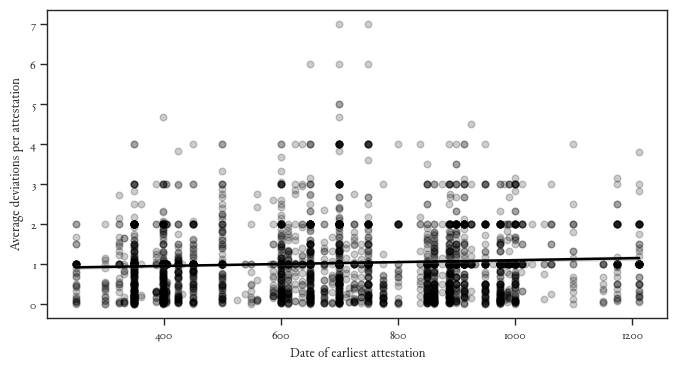

In [116]:
sns.regplot(x="earliest_attestation", y="deviation_rate", data=per_lemma, scatter_kws={'alpha':0.2}, color="black")
plt.ylabel("Average deviations per attestation")
plt.xlabel("Date of earliest attestation")
write_figure("deviation_rate_by_earliest_attestation")
scipy.stats.spearmanr(per_lemma["earliest_attestation"], per_lemma["deviation_rate"])

***

# Misc

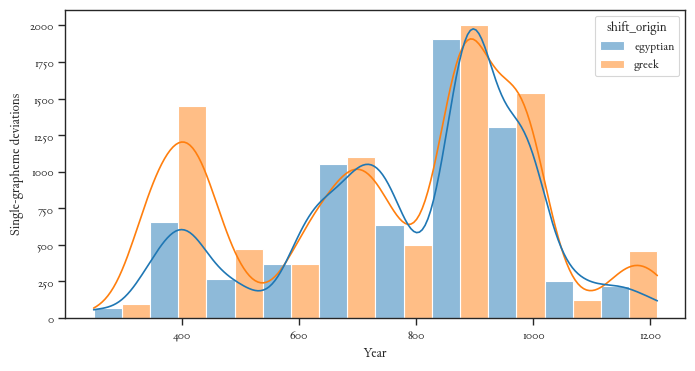

In [117]:
sns.histplot(df_diff, x="date_approximate", hue="shift_origin", multiple="dodge", kde=True, bins=number_of_bins)
plt.xlabel("Year")
plt.ylabel("Single-grapheme deviations")
write_figure("greek_non_greek")

<Axes: xlabel='date_approximate', ylabel='Count'>

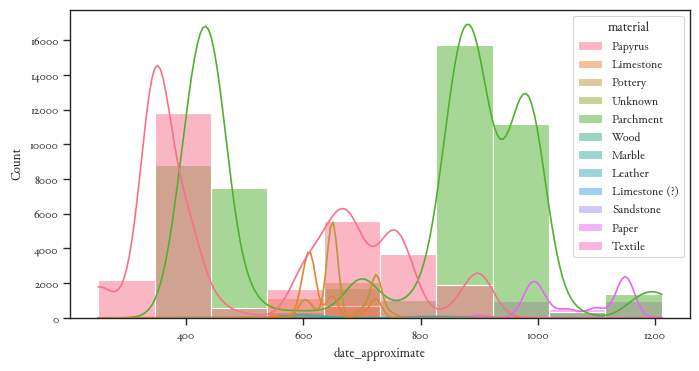

In [118]:
sns.histplot(df_attestations, x="date_approximate", hue="material", bins=number_of_bins, kde=True)

## Spelling of common words is more consistent

/tmp/nix-shell.wTW14Y/ipykernel_2124977/707813195.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frequency_df = pd.DataFrame({"attestations": df_attestations["greek_lemma"].value_counts(), "deviations": df_attestations["greek_lemma"].value_counts(), "unique_variants": df_attestations.groupby("greek_lemma")["orthography_clean"].nunique(), "entropy": df_attestations.groupby("greek_lemma").apply(lambda g: scipy.stats.entropy(g["orthography_clean"].value_counts(normalize=True)))


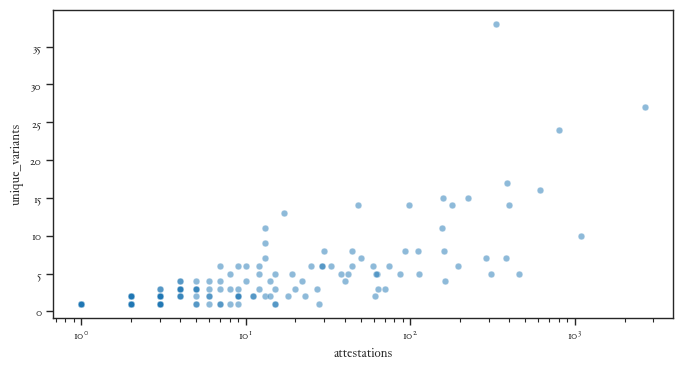

In [119]:
frequency_df = pd.DataFrame({"attestations": df_attestations["greek_lemma"].value_counts(), "deviations": df_attestations["greek_lemma"].value_counts(), "unique_variants": df_attestations.groupby("greek_lemma")["orthography_clean"].nunique(), "entropy": df_attestations.groupby("greek_lemma").apply(lambda g: scipy.stats.entropy(g["orthography_clean"].value_counts(normalize=True)))
}).dropna().sample(200)
#scipy.stats.spearmanr()

sns.scatterplot(frequency_df, y="unique_variants", x="attestations", alpha=0.5)
plt.xscale("log")


## Vowel confusion is more likely at right word edge?

<Axes: >

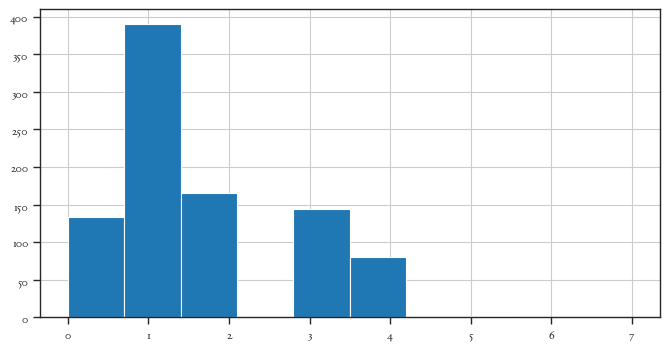

In [120]:
df_diff[df_diff["norm"].isin({"ⲁ", "ⲟ", "ⲉ"}) & df_diff["var"].isin({"ⲁ", "ⲟ", "ⲉ"})]["context_right"].str.count(r"[ⲁⲉⲓⲟⲩⲱⲏ]").hist()

<Axes: >

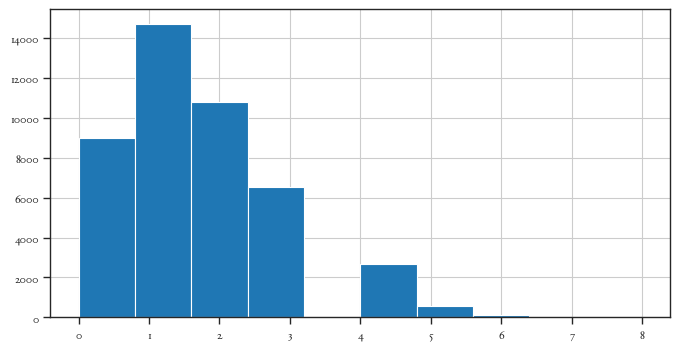

In [121]:
df_diff["context_right"].str.count(r"[ⲁⲉⲓⲟⲩⲱⲏ]").hist()

In [122]:
df_diff[df_diff["norm"].isin(vowels) & (df_diff["var"] == 2 * df_diff["norm"])].sample(10)

,id,norm,var,context_left,context_right,greek_lemma,greek_lemma_original,orthography,orthography_clean,dialect,dialect_group,manuscript_text,date_approximate,earliest,latest,century,shift_class,shift_origin,palatalization_type
7592,192260,ⲏ,ⲏⲏ,ⲡ,ⲥⲥⲱ,ⲡⲏⲥⲥⲱ,πήσσω,ⲡⲏⲏⲥⲉ,ⲡⲏⲏⲥⲉ,L4,L,Berlin Kephalaia Codex - The Kephalaia of the ...,404.0,375.0,433.0,5.0,gemination,greek,other
9288,35144,ⲟ,ⲟⲟ,ⲗ,ⲅⲟⲥ,ⲗⲟⲅⲟⲥ,λόγος,ⲗⲟ|[ⲟ]ⲅⲟⲥ,ⲗⲟⲟⲅⲟⲥ,S,S,New York - Metropolitan Museum of Art 14.1.84 ...,524.5,500.0,549.0,6.0,gemination,greek,other
22567,85629,ⲓ,ⲓⲓ,ⲇⲏⲙ,ⲟⲩⲣⲅⲟⲥ,ⲇⲏⲙⲓⲟⲩⲣⲅⲟⲥ,δημιουργός,ⲇ[ⲩⲙⲓ]|ⲓⲟⲩⲣⲅⲟⲥ,ⲇⲩⲙⲓⲓⲟⲩⲣⲅⲟⲥ,S,S,Pierpont Morgan M.595 - Homily on the Passion ...,849.5,825.0,874.0,9.0,gemination,greek,other
4241,149831,ⲟ,ⲟⲟ,ⲧⲣ,ⲫⲏ#,ⲧⲣⲟⲫⲏ,τροφή,ⲧⲣⲩ\ⲫⲟⲟⲩⲉ,ⲧⲣⲩⲫⲟⲟⲩⲉ,S,S,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,gemination,greek,other
22262,150142,ⲁ,ⲁⲁ,ⲉ,ⲣ,ⲉⲁⲣ,ἔαρ,ⲉⲁⲁⲣ,ⲉⲁⲁⲣ,S,S,New York - The Morgan Library and Museum M.586...,837.0,825.0,849.0,9.0,gemination,greek,other
33518,107620,ⲱ,ⲱⲱ,ⲇⲓ,ⲅⲙⲟⲥ,ⲇⲓⲱⲅⲙⲟⲥ,διωγμός,ⲇⲓⲱⲱⲅⲙⲟⲥ,ⲇⲓⲱⲱⲅⲙⲟⲥ,S,S,INTF Acta* (sahidic) - Acts of the Apostles,NaN,NaN,NaN,NaN,gemination,greek,other
42700,198574,ⲟ,ⲟⲟ,ⲡⲣⲟⲓⲕⲱⲓ,ⲥ#,ⲡⲣⲟⲓⲕⲱⲓⲟⲥ,προικῷος,[ⲡⲣⲟⲓ]ⲕ̣ⲟⲟⲛ,ⲡⲣⲟⲓⲕⲟⲟⲛ,S,S,London - British Library Pap 1728 Ro + Pap 174...,NaN,NaN,NaN,NaN,gemination,greek,other
12454,193598,ⲱ,ⲱⲱ,ⲉⲡ,ⲙⲓⲥ,ⲉⲡⲱⲙⲓⲥ,ἐπωμίς,ⲁⲡⲱⲱⲙⲏⲥ,ⲁⲡⲱⲱⲙⲏⲥ,S,S,Vienna - Nationalbibliothek K 1266 - CPR XII 1...,649.5,600.0,699.0,7.0,gemination,greek,other
5514,60626,ⲟ,ⲟⲟ,ⲡⲣ,ⲉⲓⲙⲓ#,ⲡⲣⲟⲉⲓⲙⲓ,πρόειμι,ⲡⲣⲟ//|ⲟⲛⲧⲟⲥ,ⲡⲣⲟⲟⲛⲧⲟⲥ,S,S,Nag Hammadi Codex III - Eugnostos the Blessed,NaN,NaN,NaN,NaN,gemination,greek,other
42706,198583,ⲟ,ⲟⲟ,ⲡⲣⲟⲓⲕⲱⲓ,ⲥ#,ⲡⲣⲟⲓⲕⲱⲓⲟⲥ,προικῷος,[ⲡ]ⲣⲟⲓⲕⲟⲟⲛ,ⲡⲣⲟⲓⲕⲟⲟⲛ,S,S,London - British Library Pap 1728 Ro + Pap 174...,NaN,NaN,NaN,NaN,gemination,greek,other


In [123]:
df_attestations.coptic_lemma.value_counts().head(50)

coptic_lemma
ⲇⲉ           15926
ⲅⲁⲣ           5109
ⲁⲗⲗⲁ          4331
ⲏ             3962
ⲕⲁⲧⲁ          3804
ⲟⲩⲇⲉ          2724
ⲯⲩⲭⲏ          2622
ⲭⲣⲓⲥⲧⲟⲥ       2414
ⲡⲛⲉⲩⲙⲁ        2379
ⲥⲱⲙⲁ          2032
ⲕⲟⲥⲙⲟⲥ        1838
ⲁⲅⲅⲉⲗⲟⲥ       1739
ⲧⲟⲡⲟⲥ         1686
ⲱ             1643
ⲙⲉⲛ           1481
ⲡⲟⲗⲓⲥ         1421
ⲙⲩⲥⲧⲏⲣⲓⲟⲛ     1392
ⲁⲓⲱⲛ          1260
ⲉⲓⲧⲉ          1116
ⲙⲁⲑⲏⲧⲏⲥ       1095
ⲥⲱⲧⲏⲣ         1084
ⲁⲅⲓⲟⲥ         1068
ⲗⲁⲟⲥ          1015
ⲡⲓⲥⲧⲓⲥ         987
ⲁⲣⲭⲱⲛ          930
ⲧⲟⲧⲉ           914
ϩⲱⲥ            898
ⲡⲓⲥⲧⲉⲩⲉ        894
ϩⲁⲙⲏⲛ          881
ⲇⲓⲕⲁⲓⲟⲥ        877
ⲡⲣⲟⲫⲏⲧⲏⲥ       862
ⲥⲟⲫⲓⲁ          858
ⲛⲟⲙⲟⲥ          839
ⲟⲩⲛ            836
ⲉⲕⲕⲗⲏⲥⲓⲁ       829
ⲉⲡⲉⲓⲇⲏ         797
ⲁⲡⲟⲥⲧⲟⲗⲟⲥ      765
ⲥⲁⲣⲝ           700
ⲙⲏ             699
ⲓⲟⲩⲇⲁⲓ         684
ⲡⲣⲟⲥ           676
ⲗⲟⲅⲟⲥ          663
ⲡⲁⲣⲑⲉⲛⲟⲥ       652
ⲁⲅⲁⲡⲏ          647
ⲉⲓⲣⲏⲛⲏ         646
incertum       632
ⲙⲁⲕⲁⲣⲓⲟⲥ       626
ⲉⲝⲟⲩⲥⲓⲁ        625
ϩⲉⲑⲛⲟⲥ         611
ⲕⲁⲗⲱⲥ          599
Name: count, dtype: int64

In [124]:
df_diff["manuscript_text"].value_counts()

manuscript_text
Cairo - IFAO P.No. unknown - P.Méd.Copt. IFAO (medical prescriptions)                                  1233
Oxford - Bodleian Hunt 393 - Treatise on the Mystery of the Letters, The                                807
New York - The Morgan Library and Museum M575 - Antiphonary                                             787
New York - The Morgan Library and Museum M.578 - Life of Samuel of Kalamun                              698
Cairo, Coptic Museum EG-c Ms 3811 - Panegyric on Macarios of Tkow                                       549
                                                                                                       ... 
Paris - Bibliothèque Nationale Copte 131.7.50 - Life of Pachom (early collection)                         1
Cairo - Egyptian Museum CG 8227 - O.Crum 398                                                              1
Cairo - Coptic Museum JdE 46304 . 104 - P.Mon.Epiph. 248                                                  1
London - Bri

In [125]:
df_attestations[df_attestations.orthography == "ⲇⲉⲙⲟⲛ"]

,id,quote_coptic,quote_english,orthography,encoding,coptic_lemma_id,coptic_lemma,coptic_lemma2,greek_lemma_id,greek_lemma,...,dialect,name,date_approximate,century,orthography_clean,greek_lemma_original,accuracy,era,rolling_average_accuracy,bin
138344,116316,ⲁⲛⲟⲕ ⲇⲉ ⲡⲉϫⲁⲓ ⲛⲁϥ ϫⲉ | ⲙⲡⲱⲣ ⲡⲁϣⲏⲣⲉ ⲙ̄ⲡⲉⲣ|ϣ̄ⲁϫⲉ...,But I said to him: No.my son.do not speak agai...,ⲇⲉⲙⲟⲛ,nn.gen0.num0.dt0,563,ⲇⲁⲓⲙⲱⲛ,ⲇⲁⲓⲙⲱⲛ,449,ⲇⲁⲓⲙⲱⲛ,...,S,Sahidic,NaN,NaN,ⲇⲉⲙⲟⲛ,δαίμων,0.545455,NaN,0.849759,NaN
